In [1]:
import os
import sys
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
import SimpleITK as sitk
from tifffile import imwrite

In [2]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')

In [8]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [4]:
filename = 'allen_10um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixed_volume = io.imread(fixedFilepath)
print(f'Fixed volume shape={fixed_volume.shape} dtype={fixed_volume.dtype}')

Fixed volume shape=(1140, 800, 1320) dtype=uint16


In [5]:
fixed_midpoint = fixed_volume.shape[0] // 2
fixed_image = fixed_volume[fixed_midpoint,:,:]
del fixed_volume
print(f'Fixed image shape={fixed_image.shape} dtype={fixed_image.dtype}')

Fixed image shape=(800, 1320) dtype=uint16


In [22]:
# moving_volume around x=1200, y = 750 for 10um
# moving volume around x=600, y=350 for 25um
files = os.listdir(os.path.join(DATA, 'thumbnail_aligned'))
midpoint = len(files) // 2
filename = f'{midpoint}.tif'
movingFilepath = os.path.join(DATA, 'thumbnail_aligned', filename)
moving_image = io.imread(movingFilepath)
print(f'Shape of {filename}: {moving_image.shape}')
moving_image = moving_image[200:-200,200:-200]
#print(f'Shape of {filename}: {moving_image.shape}')

Shape of 243.tif: (1109, 2047)


In [ ]:
fx = 65500
fy = 35500
print(fx/2252)
print(fy/1220)
1/29.85*100

In [ ]:
fixedImage = sitk.ReadImage(fixedFilepath)
movingImage = sitk.ReadImage(movingFilepath)

initial_transform = sitk.CenteredTransformInitializer(fixedImage, 
                                                    movingImage, 
                                                    sitk.Euler3DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled = sitk.Resample(movingImage, fixedImage, initial_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())
moving_volume = sitk.GetArrayFromImage(moving_resampled)

In [11]:
fixedImage = sitk.GetImageFromArray(fixed_image)
movingImage = sitk.GetImageFromArray(moving_image)
print(type(fixedImage))

<class 'SimpleITK.SimpleITK.Image'>


In [28]:
%%time
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
translateParameterMap = sitk.GetDefaultParameterMap('translation')
translateParameterMap["ResultImagePixelType"] = ["unsigned char"]
translateParameterMap["MaximumNumberOfIterations"] = ["15"] # 250 works ok        
rigidParameterMap = sitk.GetDefaultParameterMap('rigid')
rigidParameterMap["ResultImagePixelType"] = ["unsigned char"]
rigidParameterMap["MaximumNumberOfIterations"] = ["1500"] # 250 works ok        
rigidParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
rigidParameterMap["UseDirectionCosines"] = ["true"]
rigidParameterMap["NumberOfResolutions"]= ["6"]
rigidParameterMap["NumberOfSpatialSamples"] = ["4000"]
rigidParameterMap["WriteResultImage"] = ["false"]


affineParameterMap = sitk.GetDefaultParameterMap('affine')
affineParameterMap["UseDirectionCosines"] = ["true"]
affineParameterMap["MaximumNumberOfIterations"] = ["1000"] # 250 works ok
affineParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
affineParameterMap["NumberOfResolutions"]= ["6"]
affineParameterMap["NumberOfSpatialSamples"] = ["4000"]
affineParameterMap["WriteResultImage"] = ["false"]

bsplineParameterMap = sitk.GetDefaultParameterMap('bspline')
bsplineParameterMap["MaximumNumberOfIterations"] = ["1500"] # 150 works ok
bsplineParameterMap["WriteResultImage"] = ["false"]
bsplineParameterMap["UseDirectionCosines"] = ["true"]
bsplineParameterMap["FinalGridSpacingInVoxels"] = ["10"]
bsplineParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
bsplineParameterMap["NumberOfResolutions"]= ["6"]
bsplineParameterMap["GridSpacingSchedule"] = ["6.219", "4.1", "2.8", "1.9", "1.4", "1.0"]
bsplineParameterMap["NumberOfSpatialSamples"] = ["4000"]
del bsplineParameterMap["FinalGridSpacingInPhysicalUnits"]

elastixImageFilter.SetParameterMap(translateParameterMap)
elastixImageFilter.SetParameterMap(rigidParameterMap)
elastixImageFilter.AddParameterMap(affineParameterMap)
#elastixImageFilter.AddParameterMap(bsplineParameterMap)
resultImage = elastixImageFilter.Execute()

Time spent on saving the results, applying the final transform etc.: 198 ms.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0]
Scales are estimated automatically.
Scales for transform parameters are: [198517.16666666666, 1, 1]
Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 160 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the f

191	-0.227311	0.000000	241.949524	0.002431	1.0
192	-0.226282	0.000000	241.949524	0.002802	1.1
193	-0.216577	0.000000	241.949524	0.002488	1.4
194	-0.230737	0.000000	241.949524	0.001845	1.1
195	-0.223886	0.000000	241.949524	0.002658	1.0
196	-0.232257	0.000000	241.949524	0.002435	1.2
197	-0.219992	0.000000	241.949524	0.001721	1.1
198	-0.219603	0.000000	241.949524	0.002082	1.0
199	-0.235162	0.000000	241.949524	0.002226	1.0
200	-0.224910	0.000000	241.949524	0.002270	1.1
201	-0.236234	0.000000	241.949524	0.002521	1.1
202	-0.239444	0.000000	241.949524	0.001759	1.1
203	-0.232605	0.000000	241.949524	0.002054	1.0
204	-0.226368	0.000000	241.949524	0.001394	1.1
205	-0.251184	0.000000	241.949524	0.001265	1.0
206	-0.237314	0.000000	241.949524	0.001511	1.1
207	-0.222555	0.000000	241.949524	0.002240	1.2
208	-0.239585	0.000000	241.949524	0.001853	1.1
209	-0.246755	0.000000	241.949524	0.002456	1.2
210	-0.244894	0.000000	241.949524	0.001512	1.3
211	-0.250641	0.000000	241.949524	0.002371	1.1
212	-0.255473

384	-0.338086	0.000000	241.949524	0.002712	0.9
385	-0.331407	0.000000	241.949524	0.001248	1.1
386	-0.311739	0.000000	241.949524	0.001735	1.3
387	-0.319589	0.000000	241.949524	0.000857	1.1
388	-0.329409	0.000000	241.949524	0.002018	1.1
389	-0.316803	0.000000	241.949524	0.001388	1.1
390	-0.330326	0.000000	241.949524	0.002405	1.1
391	-0.336100	0.000000	241.949524	0.000826	1.1
392	-0.329464	0.000000	241.949524	0.001305	1.0
393	-0.336865	0.000000	241.949524	0.001554	1.1
394	-0.330768	0.000000	241.949524	0.001733	1.1
395	-0.320276	0.000000	241.949524	0.001663	1.1
396	-0.322403	0.000000	241.949524	0.001104	1.2
397	-0.352015	0.000000	241.949524	0.000704	1.4
398	-0.327107	0.000000	241.949524	0.001192	1.2
399	-0.330531	0.000000	241.949524	0.001738	1.2
400	-0.317312	0.000000	241.949524	0.001266	1.1
401	-0.344115	0.000000	241.949524	0.001526	1.3
402	-0.347022	0.000000	241.949524	0.001197	1.4
403	-0.336047	0.000000	241.949524	0.002292	1.6
404	-0.349674	0.000000	241.949524	0.001396	1.1
405	-0.351380

576	-0.395235	0.000000	241.949524	0.001186	1.1
577	-0.397116	0.000000	241.949524	0.001672	1.3
578	-0.403127	0.000000	241.949524	0.001026	1.2
579	-0.412935	0.000000	241.949524	0.001410	1.2
580	-0.407043	0.000000	241.949524	0.002971	1.1
581	-0.394240	0.000000	241.949524	0.000603	1.1
582	-0.411897	0.000000	241.949524	0.002334	1.1
583	-0.404766	0.000000	241.949524	0.001612	1.1
584	-0.385550	1.000000	230.951819	0.001415	1.1
585	-0.399281	0.501788	236.303138	0.001770	1.1
586	-0.403303	0.003576	241.908328	0.002088	1.4
587	-0.407153	0.000000	241.949524	0.001521	1.2
588	-0.397543	0.000000	241.949524	0.002299	1.2
589	-0.410422	0.000000	241.949524	0.001474	1.2
590	-0.398387	0.000000	241.949524	0.001330	1.1
591	-0.402542	0.000000	241.949524	0.001423	1.6
592	-0.386699	0.000000	241.949524	0.001637	1.3
593	-0.394120	0.000000	241.949524	0.001060	2.1
594	-0.407641	0.000000	241.949524	0.000701	1.1
595	-0.410910	0.000000	241.949524	0.001306	1.0
596	-0.391703	0.000000	241.949524	0.001092	1.0
597	-0.406036

769	-0.438160	0.000000	241.949524	0.001440	1.2
770	-0.438947	0.000000	241.949524	0.001032	2.3
771	-0.450084	0.000000	241.949524	0.000801	1.3
772	-0.459320	0.000000	241.949524	0.000570	1.4
773	-0.431709	0.996593	230.987590	0.001535	1.4
774	-0.441931	1.993605	220.971877	0.000987	1.5
775	-0.443993	1.495393	225.865804	0.000745	1.5
776	-0.429489	0.997181	230.981415	0.001031	1.4
777	-0.453670	0.498970	236.334117	0.000527	1.4
778	-0.444598	0.000937	241.938728	0.001409	1.4
779	-0.437993	0.000000	241.949524	0.001179	1.7
780	-0.455509	0.000000	241.949524	0.000873	1.8
781	-0.435835	0.000000	241.949524	0.000880	2.1
782	-0.461213	0.000000	241.949524	0.001431	1.4
783	-0.463227	0.000000	241.949524	0.000930	1.4
784	-0.438665	0.000000	241.949524	0.001602	1.0
785	-0.425784	0.000000	241.949524	0.001590	1.0
786	-0.436118	0.000000	241.949524	0.001511	1.0
787	-0.419935	0.000000	241.949524	0.000812	1.0
788	-0.431701	0.000000	241.949524	0.001169	1.1
789	-0.446023	0.000000	241.949524	0.000991	1.0
790	-0.439841

962	-0.486862	0.000000	241.949524	0.000772	0.9
963	-0.471664	0.000000	241.949524	0.001137	1.1
964	-0.463559	0.677669	234.385907	0.001126	1.4
965	-0.449184	1.677184	224.055154	0.001732	1.1
966	-0.453781	1.178973	229.088155	0.001322	1.1
967	-0.456518	0.680761	234.352474	0.000963	1.1
968	-0.465060	0.182549	239.864426	0.000819	1.1
969	-0.480346	0.000000	241.949524	0.001676	1.1
970	-0.455453	0.000000	241.949524	0.001325	1.0
971	-0.468818	0.000000	241.949524	0.001549	1.1
972	-0.478619	0.000000	241.949524	0.001244	1.0
973	-0.468218	0.000000	241.949524	0.000565	1.1
974	-0.469624	0.000000	241.949524	0.000683	1.1
975	-0.468618	0.000000	241.949524	0.001417	1.4
976	-0.472048	0.000000	241.949524	0.001274	1.2
977	-0.461551	0.000000	241.949524	0.001573	1.3
978	-0.458151	0.000000	241.949524	0.000889	1.1
979	-0.457395	1.000000	230.951819	0.000716	1.0
980	-0.472789	1.994983	220.958636	0.000832	1.0
981	-0.463801	1.496772	225.851962	0.001625	1.0
982	-0.454826	0.998560	230.966940	0.000981	0.9
983	-0.455366

1154	-0.506098	0.000000	241.949524	0.001656	0.9
1155	-0.517042	0.000000	241.949524	0.001955	1.2
1156	-0.527613	0.000000	241.949524	0.002664	1.4
1157	-0.507783	0.000000	241.949524	0.001803	1.1
1158	-0.518083	0.000000	241.949524	0.001764	1.1
1159	-0.518723	0.000000	241.949524	0.001753	1.1
1160	-0.510402	0.000000	241.949524	0.001713	1.2
1161	-0.520913	0.000000	241.949524	0.001855	1.1
1162	-0.542090	0.000000	241.949524	0.001069	1.1
1163	-0.530393	0.000000	241.949524	0.001973	1.1
1164	-0.510945	0.000000	241.949524	0.001493	1.1
1165	-0.516627	0.000000	241.949524	0.001631	1.1
1166	-0.517006	0.000000	241.949524	0.000818	1.3
1167	-0.513958	0.000000	241.949524	0.002229	1.5
1168	-0.514972	0.000000	241.949524	0.001218	1.4
1169	-0.507809	0.000000	241.949524	0.001443	1.3
1170	-0.512865	0.000000	241.949524	0.001434	1.0
1171	-0.532397	0.000000	241.949524	0.001300	1.0
1172	-0.510120	0.000000	241.949524	0.001442	1.0
1173	-0.523753	0.000000	241.949524	0.001573	1.0
1174	-0.524188	0.000000	241.949524	0.001

1481	-0.589510	0.000000	241.949524	0.001769	1.1
1482	-0.573533	0.000000	241.949524	0.002039	1.4
1483	-0.574098	0.000000	241.949524	0.001677	1.3
1484	-0.584468	0.000000	241.949524	0.001402	1.2
1485	-0.590101	0.000000	241.949524	0.001886	1.1
1486	-0.581551	0.000000	241.949524	0.001397	1.1
1487	-0.592878	0.999962	230.952215	0.001080	1.0
1488	-0.562813	0.501750	236.303553	0.002154	1.1
1489	-0.589609	0.003538	241.908763	0.001388	1.1
1490	-0.589999	0.000000	241.949524	0.001721	1.1
1491	-0.573703	0.000000	241.949524	0.000751	1.2
1492	-0.579247	0.000000	241.949524	0.001710	1.1
1493	-0.576397	0.999972	230.952113	0.001445	1.2
1494	-0.586793	0.502169	236.298953	0.000964	1.7
1495	-0.571001	0.003957	241.903942	0.000479	1.2
1496	-0.578320	0.000000	241.949524	0.001326	1.1
1497	-0.567138	0.000000	241.949524	0.000566	1.1
1498	-0.592738	0.000000	241.949524	0.000957	1.1
1499	-0.561947	0.000000	241.949524	0.001357	1.3
Time spent in resolution 0 (ITK initialization and iterating): 1.667 s.
Stopping conditi

148	-0.506232	4.598702	73.766655	0.000528	1.0
149	-0.535305	4.116779	75.182036	0.001278	1.1
150	-0.506631	4.119864	75.172805	0.001458	1.4
151	-0.519653	3.466072	77.181600	0.001180	1.3
152	-0.516396	2.848562	79.180061	0.002123	1.1
153	-0.493013	3.847363	75.997225	0.001619	1.1
154	-0.511599	3.168696	78.131257	0.002520	1.1
155	-0.512138	4.168607	75.027219	0.002311	1.2
156	-0.513190	5.132002	72.261230	0.000322	1.1
157	-0.510172	5.042291	72.510157	0.000965	1.1
158	-0.526046	4.850312	73.048658	0.002266	1.1
159	-0.499901	4.254380	74.772399	0.000971	1.1
160	-0.520594	3.576434	76.835012	0.002037	1.1
161	-0.520109	3.009299	78.649969	0.001829	1.2
162	-0.506562	3.797162	76.151076	0.001071	1.2
163	-0.505685	3.118988	78.292283	0.000852	1.4
164	-0.510266	2.473763	80.444307	0.000965	1.2
165	-0.518409	1.929036	82.355428	0.000819	1.5
166	-0.506358	1.819839	82.749513	0.001555	1.3
167	-0.516653	2.768738	79.445978	0.001352	1.1
168	-0.501411	3.222786	77.956788	0.001538	1.1
169	-0.524771	2.544958	80.201059	0

332	-0.504823	8.150963	64.777641	0.000990	1.0
333	-0.499212	8.169826	64.735752	0.001768	1.3
334	-0.510238	7.943011	65.243060	0.001119	1.5
335	-0.518200	8.722201	63.532664	0.001816	1.3
336	-0.508168	8.047499	65.008371	0.001168	1.4
337	-0.510009	8.942803	63.064591	0.001175	1.3
338	-0.518400	9.388880	62.138867	0.002705	1.3
339	-0.526903	10.388514	60.159923	0.001877	1.3
340	-0.515459	9.709802	61.489508	0.000912	1.3
341	-0.501979	10.703268	59.562649	0.000737	1.3
342	-0.508446	11.481311	58.135911	0.001606	1.3
343	-0.515326	11.905861	57.385844	0.002120	1.5
344	-0.543752	12.905804	55.693433	0.002377	1.2
345	-0.498387	13.901198	54.105037	0.000966	1.3
346	-0.509101	14.806034	52.737776	0.001303	1.2
347	-0.540216	14.272543	53.535426	0.002127	1.1
348	-0.521368	15.272447	52.059642	0.001375	1.0
349	-0.501339	14.604337	53.036533	0.001169	1.1
350	-0.491608	13.928496	54.062751	0.000690	1.1
351	-0.525176	14.289622	53.509517	0.001352	1.5
352	-0.513566	13.653628	54.491571	0.001397	1.2
353	-0.508582	12.9756

525	-0.531321	3.776554	76.214416	0.000362	1.1
526	-0.523744	3.441127	77.260373	0.001813	1.2
527	-0.519273	3.007705	78.655191	0.002008	1.4
528	-0.508961	4.003363	75.523066	0.001148	1.4
529	-0.501505	4.969746	72.712711	0.001712	1.3
530	-0.525194	4.977234	72.691749	0.002672	1.3
531	-0.509496	4.298806	74.641097	0.000877	1.4
532	-0.528388	3.623798	76.687220	0.000195	1.4
533	-0.509347	3.851117	75.985742	0.002501	1.3
534	-0.528471	4.260032	74.755671	0.000967	1.3
535	-0.535422	5.259820	71.909502	0.001582	1.4
536	-0.515394	6.165457	69.512197	0.001319	1.2
537	-0.510851	7.150148	67.080664	0.001930	1.4
538	-0.521557	8.147658	64.784987	0.002463	1.3
539	-0.510048	7.558842	66.120698	0.001540	1.0
540	-0.515065	6.975575	67.499259	0.002409	1.0
541	-0.528857	7.906585	65.325274	0.001682	1.0
542	-0.505687	7.227870	66.895965	0.001523	1.1
543	-0.488918	8.226203	64.610876	0.001368	1.7
544	-0.522075	9.220349	62.485400	0.002300	1.1
545	-0.507627	10.188144	60.546424	0.000643	1.1
546	-0.536314	10.049247	60.817276

716	-0.519218	25.581171	40.538496	0.001666	1.2
717	-0.521316	26.580088	39.687413	0.001061	1.2
718	-0.516156	26.416671	39.824192	0.001606	1.3
719	-0.514744	27.413054	39.004575	0.002096	1.1
720	-0.507851	26.734367	39.559142	0.001185	1.1
721	-0.523060	27.659390	38.807116	0.001601	1.1
722	-0.526037	26.983237	39.353965	0.000873	1.1
723	-0.519011	27.750700	38.734431	0.001145	1.1
724	-0.536290	27.325426	39.075302	0.000916	1.1
725	-0.515837	28.281076	38.317561	0.000670	1.0
726	-0.544308	28.864965	37.868885	0.002422	1.1
727	-0.555158	29.187235	37.625715	0.000456	1.2
728	-0.528145	28.546007	38.112670	0.001859	1.2
729	-0.524419	29.459681	37.422564	0.001259	1.3
730	-0.497603	28.786932	37.928238	0.001856	1.3
731	-0.528486	28.111331	38.449998	0.001687	1.2
732	-0.508877	29.111239	37.682776	0.001689	1.0
733	-0.542714	30.110334	36.946160	0.001237	1.0
734	-0.518502	31.004281	36.311061	0.001109	1.3
735	-0.512817	30.996446	36.316532	0.002314	1.8
736	-0.509811	31.990701	35.635132	0.001610	1.0
737	-0.523590

909	-0.519588	51.879139	25.910441	0.000431	1.1
910	-0.526838	52.082593	25.838309	0.001474	1.2
911	-0.537038	52.728357	25.611999	0.001418	1.2
912	-0.525818	52.052358	25.849003	0.001356	1.2
913	-0.502394	51.378435	26.089685	0.001837	1.1
914	-0.509542	50.699886	26.336591	0.000665	1.2
915	-0.534803	51.617032	26.003963	0.001754	1.1
916	-0.517717	51.179463	26.161605	0.002768	1.1
917	-0.507133	50.500758	26.409938	0.001075	1.1
918	-0.506176	51.098275	26.191065	0.001251	1.8
919	-0.537073	50.482247	26.416777	0.001092	1.4
920	-0.527818	50.568608	26.384901	0.000784	1.1
921	-0.538656	51.154770	26.170558	0.001089	1.2
922	-0.525308	51.933326	25.891190	0.001771	1.3
923	-0.515138	52.931423	25.541651	0.000923	1.2
924	-0.528213	53.926540	25.202426	0.000991	1.2
925	-0.516782	54.821937	24.904806	0.001026	1.2
926	-0.518461	54.912731	24.875019	0.002434	1.6
927	-0.515694	55.889013	24.559174	0.001496	1.0
928	-0.518219	55.210297	24.777893	0.001877	1.1
929	-0.513853	54.531610	25.000534	0.002491	1.0
930	-0.515884

1100	-0.530880	58.153285	23.856629	0.001258	1.1
1101	-0.515495	57.618770	24.018827	0.001577	1.2
1102	-0.512085	58.508161	23.750148	0.001150	1.1
1103	-0.516759	57.848823	23.948748	0.002030	1.2
1104	-0.534670	58.483267	23.757587	0.001197	1.2
1105	-0.494808	59.215879	23.540608	0.001550	1.2
1106	-0.524945	58.540594	23.740464	0.000838	1.1
1107	-0.509777	57.870550	23.942151	0.001296	1.2
1108	-0.523396	58.518970	23.746920	0.001083	1.1
1109	-0.532806	59.485184	23.461841	0.001325	1.1
1110	-0.520067	58.903003	23.632786	0.001246	1.2
1111	-0.532836	59.897903	23.342145	0.001726	1.1
1112	-0.510590	60.850346	23.070527	0.000546	1.1
1113	-0.512606	60.294710	23.228210	0.001361	1.2
1114	-0.523751	61.122128	22.994175	0.000684	1.3
1115	-0.525783	61.895392	22.779681	0.001790	1.5
1116	-0.524533	62.802871	22.533006	0.001655	1.3
1117	-0.550350	62.124180	22.716983	0.002161	1.4
1118	-0.508519	63.124125	22.446957	0.000842	1.1
1119	-0.516172	64.014142	22.211959	0.001006	1.0
1120	-0.493813	64.866561	21.991455	0.001

1281	-0.522560	88.492838	17.246156	0.000471	1.0
1282	-0.529676	88.741199	17.207126	0.001072	1.3
1283	-0.497416	88.831716	17.192945	0.001729	1.4
1284	-0.532524	89.827056	17.038534	0.001678	1.4
1285	-0.497383	90.826334	16.886278	0.001894	1.3
1286	-0.536294	90.147961	16.989341	0.002092	1.3
1287	-0.527339	89.472914	17.093155	0.001952	1.2
1288	-0.518226	88.794200	17.198819	0.002115	1.3
1289	-0.520326	88.115497	17.305797	0.001899	1.3
1290	-0.519449	89.115496	17.148636	0.000154	1.4
1291	-0.529001	89.475171	17.092805	0.001516	1.3
1292	-0.511904	89.171531	17.139914	0.000502	1.6
1293	-0.528041	90.038334	17.006114	0.001164	1.3
1294	-0.505221	90.128053	16.992384	0.002010	1.8
1295	-0.524315	89.455647	17.095827	0.001864	1.8
1296	-0.509933	88.776931	17.201525	0.001037	1.0
1297	-0.527077	88.109006	17.306826	0.001724	1.0
1298	-0.512149	87.479020	17.407335	0.000393	1.1
1299	-0.534975	87.089295	17.470098	0.001852	1.1
1300	-0.529130	86.707425	17.532037	0.001060	1.1
1301	-0.508088	86.399150	17.582361	0.002

1475	-0.514683	110.909288	14.315373	0.002501	0.9
1476	-0.534984	110.230592	14.389409	0.001772	1.6
1477	-0.508075	109.697469	14.448104	0.002511	1.1
1478	-0.515565	110.697464	14.338398	0.000860	1.1
1479	-0.519989	110.033846	14.411014	0.000718	1.1
1480	-0.518827	110.025313	14.411953	0.001968	1.1
1481	-0.506001	109.649303	14.453430	0.001067	1.0
1482	-0.518633	109.022522	14.523104	0.001656	1.1
1483	-0.522704	108.608878	14.569454	0.002142	1.1
1484	-0.517542	109.605063	14.458326	0.001669	1.1
1485	-0.524518	110.605060	14.348465	0.001214	1.1
1486	-0.541779	111.604101	14.240363	0.000250	1.0
1487	-0.528541	111.799768	14.219382	0.001348	1.1
1488	-0.527408	112.221979	14.174317	0.001191	1.3
1489	-0.510909	111.546443	14.246558	0.001508	1.5
1490	-0.523782	112.516817	14.143017	0.001846	1.5
1491	-0.525232	111.840686	14.215002	0.000754	1.4
1492	-0.512351	111.334903	14.269332	0.001397	1.0
1493	-0.524664	110.737711	14.334017	0.001752	1.0
1494	-0.499645	110.059200	14.408226	0.001983	1.1
1495	-0.508178	111.0

143	-0.468243	9.913638	35.889364	0.001745	1.0
144	-0.474927	9.223749	36.708576	0.002758	1.1
145	-0.476210	9.086053	36.876583	0.002500	1.2
146	-0.479001	10.084290	35.692333	0.004896	1.4
147	-0.452676	9.383372	36.515723	0.001443	1.2
148	-0.450443	8.684234	37.375760	0.003148	1.1
149	-0.475694	9.560063	36.304599	0.001178	1.1
150	-0.476130	9.909054	35.894687	0.004370	1.0
151	-0.484235	9.209238	36.726210	0.003068	1.1
152	-0.482727	10.209202	35.549477	0.002289	1.1
153	-0.467923	9.508490	36.365969	0.003260	1.1
154	-0.452732	10.508391	35.211916	0.001871	1.1
155	-0.488473	9.838165	35.977200	0.003757	1.1
156	-0.483546	10.837962	34.847419	0.002270	1.1
157	-0.488954	11.837323	33.786883	0.002504	1.2
158	-0.468908	11.139578	34.520391	0.002465	1.1
159	-0.469041	12.138489	33.479825	0.001176	1.4
160	-0.479452	11.459252	34.180419	0.000073	1.2
161	-0.462878	11.425610	34.215881	0.002430	1.3
162	-0.484382	11.441724	34.198886	0.004001	1.0
163	-0.468717	12.441688	33.176280	0.003423	1.2
164	-0.467531	13.441529

335	-0.464774	34.215099	20.093612	0.003339	1.0
336	-0.470932	35.215068	19.736182	0.004032	1.2
337	-0.475829	34.514057	19.985403	0.001031	1.3
338	-0.468023	33.838210	20.231711	0.001283	1.2
339	-0.461069	33.570796	20.330853	0.002768	1.1
340	-0.459385	32.912564	20.579077	0.001892	1.2
341	-0.472984	32.258749	20.831710	0.003450	1.8
342	-0.468495	33.258404	20.447907	0.001408	1.2
343	-0.481519	32.622882	20.690250	0.002591	1.2
344	-0.469558	31.974127	20.943636	0.002626	1.1
345	-0.475297	32.973519	20.555836	0.002767	1.1
346	-0.468455	32.303907	20.814062	0.001612	1.1
347	-0.470780	31.606434	21.090021	0.001407	1.2
348	-0.477303	31.881239	20.980424	0.001330	6.5
349	-0.460223	32.227819	20.843815	0.001709	1.2
350	-0.459263	32.964186	20.559391	0.001364	2.2
351	-0.472926	32.339668	20.800107	0.002835	1.2
352	-0.465525	32.627735	20.688377	0.002029	1.3
353	-0.446421	31.931321	20.960573	0.000341	1.5
354	-0.463074	32.148686	20.874849	0.001438	2.4
355	-0.479839	32.429151	20.765271	0.002194	1.2
356	-0.454660

694	-0.483457	50.048131	15.615763	0.000552	1.2
695	-0.474044	49.776367	15.675724	0.001151	1.2
696	-0.479751	50.065024	15.612051	0.003692	1.2
697	-0.442347	49.431773	15.752419	0.001682	1.1
698	-0.493876	49.528065	15.730912	0.004243	1.0
699	-0.470095	50.356010	15.548386	0.002075	1.0
700	-0.471302	49.657354	15.702128	0.001279	1.0
701	-0.454710	50.333968	15.553191	0.002835	1.0
702	-0.451575	50.171100	15.588783	0.003716	1.0
703	-0.453083	49.472364	15.743346	0.001541	1.0
704	-0.467474	50.471088	15.523351	0.000982	1.0
705	-0.463051	50.266071	15.568009	0.002458	1.0
706	-0.458273	50.270591	15.567021	0.000924	1.0
707	-0.450873	49.616855	15.711133	0.000722	1.0
708	-0.482610	49.530610	15.730345	0.001941	1.0
709	-0.467299	49.744612	15.682761	0.003004	1.1
710	-0.456175	50.548569	15.506541	0.003040	1.2
711	-0.466616	49.851078	15.659195	0.003429	1.1
712	-0.470168	49.217206	15.800555	0.001878	1.0
713	-0.470755	48.535724	15.955408	0.001864	1.1
714	-0.479770	48.435460	15.978447	0.001806	1.2
715	-0.462327

887	-0.471756	71.710585	11.967035	0.001432	1.1
888	-0.452118	72.447132	11.872711	0.001935	1.2
889	-0.463991	73.225883	11.774587	0.001371	1.4
890	-0.476004	72.600302	11.853282	0.001891	2.0
891	-0.468653	72.843270	11.822593	0.002094	1.1
892	-0.461966	73.821172	11.700665	0.003996	1.1
893	-0.468915	74.821077	11.578568	0.002576	1.2
894	-0.457428	74.646653	11.599683	0.003546	1.3
895	-0.475708	75.642798	11.480119	0.000652	1.2
896	-0.466406	75.326564	11.517807	0.003099	1.5
897	-0.474890	74.968708	11.560756	0.002407	1.1
898	-0.466396	75.918986	11.447404	0.002466	1.1
899	-0.489066	76.918371	11.330569	0.002867	1.2
900	-0.489399	76.754501	11.349562	0.001486	1.5
901	-0.473324	76.066818	11.429970	0.000978	1.3
902	-0.461995	76.749779	11.350111	0.001920	1.7
903	-0.481708	76.206558	11.413539	0.001107	1.1
904	-0.472647	76.650514	11.361648	0.002402	1.0
905	-0.471902	76.213640	11.412707	0.003088	1.1
906	-0.487963	75.548365	11.491348	0.001733	1.1
907	-0.478928	75.301737	11.520777	0.002168	1.3
908	-0.469268

1075	-0.453812	86.498709	10.320783	0.001327	1.0
1076	-0.483759	86.166905	10.352737	0.001881	1.2
1077	-0.463591	85.745529	10.393605	0.000683	1.3
1078	-0.456923	85.977189	10.371097	0.001735	1.2
1079	-0.454906	86.196413	10.349887	0.002431	1.2
1080	-0.485962	85.548594	10.412815	0.003391	1.4
1081	-0.474529	86.547853	10.316067	0.001118	1.0
1082	-0.458991	85.854415	10.383013	0.000877	1.2
1083	-0.476377	85.985168	10.370324	0.002202	1.2
1084	-0.470688	85.474548	10.420057	0.001556	1.3
1085	-0.469397	86.194351	10.350087	0.003061	1.0
1086	-0.476011	85.498065	10.417756	0.001031	1.0
1087	-0.476786	85.389316	10.428404	0.002564	1.1
1088	-0.481379	84.716544	10.494770	0.002226	1.4
1089	-0.456188	85.634698	10.404407	0.001955	1.3
1090	-0.490186	85.024463	10.464291	0.002079	1.4
1091	-0.488509	84.431717	10.523122	0.002079	1.0
1092	-0.472159	85.412367	10.426145	0.002029	1.0
1093	-0.450175	86.401005	10.330172	0.002043	1.0
1094	-0.463988	87.287088	10.245643	0.002493	1.0
1095	-0.483019	86.839213	10.288195	0.002

1267	-0.452462	94.728161	9.586870	0.001768	1.0
1268	-0.484702	95.696391	9.507328	0.001161	1.3
1269	-0.483732	95.346161	9.535947	0.000531	1.9
1270	-0.475083	95.509352	9.522590	0.001384	1.1
1271	-0.471419	95.592072	9.515834	0.001765	1.1
1272	-0.468372	95.143160	9.552614	0.002063	1.1
1273	-0.455539	95.924563	9.488774	0.003382	1.1
1274	-0.470368	95.223649	9.545999	0.002077	1.1
1275	-0.471970	94.523489	9.603855	0.002109	1.1
1276	-0.450275	94.120491	9.637475	0.001356	1.1
1277	-0.474035	94.881192	9.574210	0.002102	1.1
1278	-0.477066	94.246784	9.626913	0.001752	1.1
1279	-0.466150	95.232428	9.545278	0.004326	1.1
1280	-0.514182	94.574509	9.599615	0.003152	1.1
1281	-0.474411	93.873498	9.658196	0.000744	1.3
1282	-0.459616	94.176595	9.632780	0.001569	1.2
1283	-0.484857	93.890741	9.656747	0.001184	1.2
1284	-0.475802	94.427195	9.611867	0.001443	1.0
1285	-0.456634	94.874950	9.574725	0.002149	1.0
1286	-0.483702	95.522026	9.521554	0.003050	1.1
1287	-0.470610	96.488095	9.443262	0.001956	1.1
1288	-0.47782

1460	-0.484231	122.263320	7.744277	0.001112	1.0
1461	-0.470283	121.651731	7.777479	0.001502	1.3
1462	-0.459060	121.668591	7.776560	0.002124	1.2
1463	-0.464695	122.288658	7.742907	0.002495	1.1
1464	-0.459985	121.592675	7.780700	0.001610	1.2
1465	-0.483337	121.004263	7.812940	0.003039	1.1
1466	-0.460300	121.834607	7.767521	0.002151	1.1
1467	-0.488852	121.133738	7.805823	0.001192	1.1
1468	-0.467477	122.054003	7.755608	0.001449	1.1
1469	-0.475922	122.407096	7.736513	0.002271	1.1
1470	-0.457259	122.152460	7.750274	0.001922	1.1
1471	-0.457831	122.471287	7.733051	0.002211	1.1
1472	-0.460183	123.371034	7.684857	0.002178	1.1
1473	-0.496398	123.381360	7.684308	0.001230	1.2
1474	-0.476320	123.202572	7.693835	0.002057	1.4
1475	-0.475108	123.264213	7.690548	0.004160	1.4
1476	-0.450215	122.563378	7.728091	0.001528	1.2
1477	-0.478419	123.509049	7.677518	0.002244	1.1
1478	-0.477498	122.874522	7.711378	0.001595	1.0
1479	-0.460418	122.200972	7.747649	0.001907	1.1
1480	-0.469245	122.871731	7.711528	0.001

121	-0.429946	23.284776	22.611764	0.002693	1.2
122	-0.432515	24.284007	22.112816	0.002107	1.6
123	-0.427655	23.710812	22.396304	0.002349	1.2
124	-0.429893	23.904569	22.299667	0.001674	1.2
125	-0.434482	23.697402	22.403023	0.001165	1.2
126	-0.435725	23.071772	22.721049	0.003195	1.1
127	-0.423943	24.021932	22.241536	0.002724	1.2
128	-0.433961	23.453182	22.526102	0.003224	1.2
129	-0.443522	22.712039	22.908035	0.004692	1.1
130	-0.410726	21.958317	23.309966	0.002673	1.1
131	-0.425656	22.228456	23.164300	0.003716	1.0
132	-0.413627	21.475194	23.575099	0.003034	1.1
133	-0.411643	22.473132	23.033926	0.001990	1.1
134	-0.432653	21.787944	23.402782	0.002699	1.1
135	-0.448109	22.601121	22.966311	0.006827	1.1
136	-0.443698	23.601120	22.451385	0.003292	1.2
137	-0.419786	22.847395	22.837318	0.004524	1.3
138	-0.420991	23.847389	22.328098	0.005582	1.5
139	-0.422405	23.093664	22.709769	0.001859	1.3
140	-0.447732	24.093660	22.206157	0.003612	1.9
141	-0.416780	23.343049	22.582049	0.005230	1.3
142	-0.449787

320	-0.428793	33.908858	18.236710	0.002939	1.1
321	-0.424523	34.908574	17.910614	0.005135	1.2
322	-0.439730	34.156538	18.154818	0.002140	1.4
323	-0.432020	33.402841	18.406335	0.003150	1.0
324	-0.431800	32.655194	18.662814	0.003770	1.1
325	-0.445336	31.922016	18.921368	0.004158	1.1
326	-0.433597	31.168699	19.194592	0.003512	1.0
327	-0.438370	32.115402	18.852477	0.002435	1.0
328	-0.446772	33.096606	18.510531	0.006874	1.0
329	-0.428756	32.342881	18.772082	0.005044	1.0
330	-0.438423	31.589559	19.040983	0.004430	1.1
331	-0.419336	32.589559	18.685672	0.001539	1.1
332	-0.432484	31.916384	18.923381	0.004737	1.3
333	-0.435986	32.899470	18.578233	0.000867	1.4
334	-0.441196	33.812308	18.268833	0.001253	1.7
335	-0.440559	33.729412	18.296504	0.002566	1.5
336	-0.430982	34.245950	18.125436	0.003656	1.1
337	-0.440913	33.662403	18.318933	0.003641	1.3
338	-0.435399	32.964097	18.555984	0.000747	1.9
339	-0.441846	33.053838	18.525177	0.004780	1.2
340	-0.431749	33.187729	18.479404	0.000945	1.1
341	-0.434107

498	-0.445439	60.663834	12.261939	0.008379	1.1
499	-0.444491	59.910109	12.376166	0.003990	2.1
500	-0.424390	59.156384	12.492541	0.004644	1.3
501	-0.426290	58.402659	12.611126	0.001918	1.7
502	-0.437562	57.740542	12.717171	0.003611	1.4
503	-0.450740	57.066877	12.826911	0.002821	1.2
504	-0.429358	56.317804	12.951181	0.003001	1.3
505	-0.428912	55.630441	13.067352	0.003384	1.1
506	-0.439658	56.630091	12.899082	0.002917	1.1
507	-0.420723	55.878217	13.025236	0.001595	1.1
508	-0.434211	55.936828	13.015313	0.005077	1.0
509	-0.420060	56.916306	12.851699	0.005375	1.1
510	-0.440797	57.916300	12.688848	0.004989	1.3
511	-0.444063	57.162576	12.811207	0.004476	1.3
512	-0.442770	56.409718	12.935804	0.004499	1.1
513	-0.425836	57.409718	12.770827	0.002679	1.2
514	-0.434781	56.691265	12.888925	0.002358	1.8
515	-0.442011	56.539811	12.914100	0.000830	1.5
516	-0.437880	56.364113	12.943429	0.006234	1.9
517	-0.431316	55.986284	13.006952	0.004052	1.2
518	-0.419487	56.986280	12.840168	0.002545	1.2
519	-0.437273

685	-0.433062	85.578365	9.395499	0.004207	1.1
686	-0.439328	86.578361	9.308163	0.003722	1.3
687	-0.443260	86.815269	9.287710	0.006169	1.2
688	-0.443748	87.815269	9.202357	0.005063	1.1
689	-0.432028	88.815204	9.118563	0.002131	1.1
690	-0.436118	88.061488	9.181581	0.004371	1.1
691	-0.431516	89.061279	9.098176	0.003383	1.1
692	-0.417306	90.061279	9.016256	0.003921	1.4
693	-0.434733	91.061260	8.935799	0.004457	1.1
694	-0.439602	92.054019	8.857331	0.005178	1.1
695	-0.451510	91.300346	8.916775	0.004556	1.0
696	-0.435157	92.300344	8.838075	0.003505	1.1
697	-0.435308	91.550347	8.896969	0.002494	1.1
698	-0.425266	92.550100	8.818635	0.003060	1.5
699	-0.435069	93.521526	8.743831	0.003248	1.2
700	-0.450728	92.771409	8.801481	0.003913	1.6
701	-0.423494	92.023318	8.859737	0.003589	1.4
702	-0.452500	91.269632	8.919214	0.001978	1.8
703	-0.426314	90.616817	8.971380	0.006213	1.0
704	-0.429200	89.863278	9.032359	0.003816	1.1
705	-0.430257	89.109553	9.094187	0.002275	1.0
706	-0.425496	90.109500	9.012343	0

876	-0.439911	117.676687	7.220802	0.004363	1.0
877	-0.446195	117.660420	7.221649	0.003124	1.2
878	-0.424323	118.654284	7.170256	0.002061	1.3
879	-0.426903	119.455986	7.129329	0.001777	1.2
880	-0.449621	118.732000	7.166268	0.003243	1.1
881	-0.427612	119.692601	7.117339	0.001443	1.1
882	-0.443929	119.114941	7.146682	0.002625	1.1
883	-0.437323	118.514027	7.177464	0.004221	1.1
884	-0.433978	117.807483	7.213998	0.004025	1.1
885	-0.441124	118.777357	7.163942	0.004491	1.1
886	-0.442017	119.777357	7.113054	0.006120	1.1
887	-0.452081	119.023636	7.151342	0.003074	1.1
888	-0.444730	120.023579	7.100635	0.001065	1.2
889	-0.431136	120.315117	7.085986	0.004485	1.1
890	-0.422870	121.310027	7.036447	0.003078	1.3
891	-0.434054	122.308224	6.987435	0.000843	1.2
892	-0.430534	122.874063	6.959954	0.005314	1.4
893	-0.453692	123.400305	6.934590	0.004274	1.3
894	-0.443034	122.668776	6.969899	0.001063	1.6
895	-0.437682	121.925081	7.006167	0.003532	1.1
896	-0.442028	122.001692	7.002413	0.005974	1.0
897	-0.438482

1075	-0.440722	136.041622	6.376379	0.003289	1.0
1076	-0.439239	137.041583	6.336034	0.001779	1.4
1077	-0.433721	136.407966	6.361539	0.002354	1.2
1078	-0.437984	135.665433	6.391690	0.005017	1.0
1079	-0.431936	135.392096	6.402861	0.002058	1.1
1080	-0.431828	136.391991	6.362185	0.004283	1.1
1081	-0.431410	135.653549	6.392175	0.000859	1.2
1082	-0.431832	136.599381	6.353812	0.004842	1.1
1083	-0.423395	135.879960	6.382950	0.002796	1.5
1084	-0.435742	135.809133	6.385833	0.002620	1.2
1085	-0.431889	136.808691	6.345385	0.002582	2.0
1086	-0.416666	137.775354	6.306753	0.003790	1.2
1087	-0.450764	137.044594	6.335914	0.000581	1.2
1088	-0.437440	136.819193	6.344963	0.003417	1.5
1089	-0.444449	137.641147	6.312088	0.003692	1.7
1090	-0.431411	138.555164	6.275929	0.003443	1.4
1091	-0.420756	138.359469	6.283636	0.002399	1.0
1092	-0.418056	137.605806	6.313495	0.001727	1.1
1093	-0.437692	138.498617	6.278154	0.001988	1.1
1094	-0.421761	139.374478	6.243867	0.000835	1.1
1095	-0.416716	139.227603	6.249591	0.003

1268	-0.448228	166.309777	5.345994	0.005278	0.9
1269	-0.430965	167.294614	5.318033	0.004854	1.5
1270	-0.431991	168.294614	5.289939	0.003208	1.4
1271	-0.441600	167.540889	5.311086	0.002214	1.1
1272	-0.408113	168.539859	5.283094	0.001776	1.1
1273	-0.444261	168.074482	5.296098	0.003251	1.1
1274	-0.433728	169.057833	5.268696	0.002699	1.0
1275	-0.438787	168.309414	5.289525	0.004453	2.0
1276	-0.421950	167.861654	5.302066	0.004258	1.1
1277	-0.431388	168.861654	5.274140	0.003703	1.2
1278	-0.446590	169.861654	5.246507	0.002633	1.2
1279	-0.440476	170.861616	5.219162	0.003343	1.2
1280	-0.461370	171.861479	5.192104	0.004834	1.2
1281	-0.433453	171.209913	5.209705	0.002754	1.2
1282	-0.425984	172.209866	5.182742	0.004261	1.2
1283	-0.447266	173.195886	5.156427	0.002586	1.4
1284	-0.419684	172.445320	5.176434	0.001190	1.4
1285	-0.435086	172.503966	5.174865	0.005789	1.1
1286	-0.423026	171.757982	5.194892	0.001478	1.0
1287	-0.431239	171.007337	5.215201	0.004437	1.0
1288	-0.431153	170.690746	5.223815	0.004

1459	-0.407368	190.280343	4.739470	0.003983	1.1
1460	-0.447918	189.526618	4.756439	0.002583	1.3
1461	-0.451325	190.523944	4.734012	0.002068	1.1
1462	-0.448597	190.016970	4.745386	0.003278	1.1
1463	-0.442803	189.289824	4.761794	0.007436	1.0
1464	-0.436249	188.536099	4.778923	0.005820	1.0
1465	-0.416852	189.536099	4.756224	0.004137	1.1
1466	-0.435835	190.536099	4.733740	0.001507	1.1
1467	-0.436969	191.533939	4.711515	0.007912	1.0
1468	-0.422960	190.780215	4.728284	0.004217	1.0
1469	-0.434909	191.736040	4.707039	0.003101	1.1
1470	-0.441900	190.982315	4.723776	0.002409	1.4
1471	-0.420176	191.970137	4.701865	0.003224	1.3
1472	-0.441477	191.276471	4.717230	0.005716	1.5
1473	-0.422280	190.522746	4.734039	0.002548	1.8
1474	-0.440324	189.769021	4.750968	0.003235	1.2
1475	-0.432097	189.015401	4.768017	0.002592	1.2
1476	-0.429120	188.261784	4.785188	0.006421	1.0
1477	-0.430475	187.508063	4.802485	0.003111	1.0
1478	-0.432392	186.754338	4.819909	0.002921	0.9
1479	-0.431166	187.749340	4.796935	0.004

130	-0.419925	17.410298	9.378120	0.005840	1.3
131	-0.409822	18.400535	9.142424	0.004992	1.1
132	-0.407941	19.171624	8.966936	0.005524	1.2
133	-0.399747	18.613424	9.093291	0.010678	1.3
134	-0.401429	18.501220	9.119121	0.006023	1.1
135	-0.407321	18.701328	9.073157	0.004506	1.3
136	-0.415506	18.468578	9.126663	0.010685	1.1
137	-0.411422	19.452922	8.904583	0.011598	1.0
138	-0.391521	18.848048	9.039750	0.003673	1.0
139	-0.401700	18.370223	9.149463	0.003856	1.0
140	-0.413302	18.655730	9.083590	0.006355	1.0
141	-0.408197	19.521247	8.889568	0.009907	1.0
142	-0.407861	18.973419	9.011398	0.007908	1.1
143	-0.426800	19.210626	8.958239	0.004785	1.0
144	-0.391478	19.720579	8.846053	0.003233	1.0
145	-0.409300	19.378335	8.921031	0.005067	1.0
146	-0.416788	19.366427	8.923663	0.006895	1.2
147	-0.413306	20.306841	8.720502	0.000754	1.2
148	-0.413277	20.448912	8.690611	0.002857	1.2
149	-0.404249	20.359131	8.709477	0.005131	1.3
150	-0.389295	19.964077	8.793470	0.002211	1.1
151	-0.394079	19.781615	8.832813	0

322	-0.399396	37.911037	6.114582	0.007178	1.0
323	-0.411016	37.313890	6.177197	0.004559	1.2
324	-0.413317	37.665270	6.140198	0.002637	1.4
325	-0.404114	37.282794	6.180493	0.004053	1.1
326	-0.420387	37.793143	6.126844	0.001192	1.1
327	-0.415255	37.787853	6.127395	0.005652	1.2
328	-0.400675	37.531340	6.154248	0.013377	1.1
329	-0.417331	38.479746	6.056119	0.002817	1.1
330	-0.413346	39.436733	5.960223	0.003869	1.1
331	-0.404685	39.183797	5.985272	0.007995	1.3
332	-0.400518	39.112726	5.992348	0.007497	1.1
333	-0.407657	40.097219	5.895790	0.006469	1.1
334	-0.415603	41.091887	5.801344	0.010132	1.1
335	-0.414399	40.872278	5.821935	0.003454	1.1
336	-0.399902	41.565829	5.757398	0.005878	1.3
337	-0.407509	41.838405	5.732424	0.006441	1.5
338	-0.403557	41.417251	5.771103	0.006339	1.3
339	-0.407387	42.373273	5.684043	0.005993	1.0
340	-0.391942	41.789598	5.736880	0.003632	1.0
341	-0.408023	42.484762	5.674061	0.005529	1.1
342	-0.402420	43.152869	5.614969	0.007538	1.0
343	-0.413868	44.137364	5.530104	0

519	-0.398702	56.770011	4.631816	0.007927	1.0
520	-0.406770	56.173303	4.667630	0.003566	1.0
521	-0.410689	56.610494	4.641336	0.009124	1.3
522	-0.427675	56.042276	4.675568	0.007011	1.3
523	-0.419860	57.040730	4.615749	0.001452	1.4
524	-0.398108	57.532076	4.586870	0.004044	1.2
525	-0.410240	57.725091	4.575624	0.008875	1.2
526	-0.399401	57.181350	4.607447	0.002754	1.8
527	-0.429856	57.711634	4.576406	0.007371	1.1
528	-0.415540	57.240575	4.603959	0.003844	1.1
529	-0.421769	57.125794	4.610723	0.009801	1.2
530	-0.414136	57.142329	4.609747	0.007824	1.0
531	-0.409900	58.047656	4.556952	0.007398	1.0
532	-0.421920	58.812927	4.513259	0.008314	1.0
533	-0.412278	58.231946	4.546353	0.012468	1.1
534	-0.403787	59.229467	4.489827	0.004134	1.3
535	-0.412020	58.650505	4.522462	0.008712	1.4
536	-0.410631	59.624460	4.467830	0.008793	1.0
537	-0.411852	60.620581	4.413303	0.009072	1.0
538	-0.394181	61.591885	4.361402	0.004905	1.0
539	-0.415861	60.989980	4.393420	0.005315	0.9
540	-0.431984	61.669541	4.357305	0

703	-0.421995	70.005583	3.958179	0.003962	0.9
704	-0.422504	70.151473	3.951844	0.003945	1.1
705	-0.412370	70.668419	3.929558	0.010269	1.3
706	-0.398881	70.068787	3.955432	0.008960	1.1
707	-0.409167	69.463591	3.981894	0.006036	1.3
708	-0.414822	70.160689	3.951444	0.005134	1.1
709	-0.396994	70.979256	3.916279	0.008739	1.1
710	-0.409059	70.510274	3.936349	0.004549	1.1
711	-0.408430	71.470555	3.895471	0.004931	1.0
712	-0.394968	71.786118	3.882223	0.003735	1.1
713	-0.413002	71.511209	3.893759	0.007264	1.2
714	-0.399427	70.947371	3.917637	0.005333	2.5
715	-0.405240	70.383882	3.941793	0.005283	1.4
716	-0.419774	69.909873	3.962346	0.006638	1.4
717	-0.414525	69.369706	3.986030	0.006007	1.5
718	-0.403084	70.316928	3.944684	0.006798	1.0
719	-0.420402	70.801312	3.923870	0.003889	1.0
720	-0.402189	70.344692	3.943485	0.007427	1.0
721	-0.407588	70.691242	3.928580	0.010508	1.0
722	-0.409680	70.327988	3.944206	0.002452	0.9
723	-0.422814	69.897566	3.962883	0.006892	1.1
724	-0.408139	70.633304	3.931064	0

896	-0.414967	80.100374	3.562958	0.007648	1.0
897	-0.407229	79.536387	3.582945	0.011284	1.2
898	-0.384250	80.499414	3.548950	0.002140	1.2
899	-0.420488	80.000307	3.566488	0.008258	1.3
900	-0.389665	80.045601	3.564889	0.003122	1.3
901	-0.397866	79.484676	3.584789	0.009665	1.1
902	-0.416495	79.001379	3.602114	0.003062	1.1
903	-0.426516	79.930581	3.568952	0.007510	1.0
904	-0.406105	79.415174	3.587270	0.003971	1.1
905	-0.400324	78.918926	3.605087	0.003409	1.0
906	-0.415254	79.307805	3.591110	0.006436	1.4
907	-0.392628	78.914239	3.605256	0.008015	1.2
908	-0.409768	79.882965	3.570636	0.002815	1.1
909	-0.426875	79.695536	3.577283	0.007805	1.1
910	-0.405319	80.473173	3.549868	0.008808	1.4
911	-0.425030	79.877486	3.570830	0.008421	1.2
912	-0.400499	79.272232	3.592384	0.003677	1.3
913	-0.418915	79.867469	3.571185	0.004739	1.0
914	-0.423556	79.401794	3.587749	0.008593	1.0
915	-0.398634	80.297734	3.556016	0.014258	0.9
916	-0.411227	79.692259	3.577399	0.002413	1.0
917	-0.395813	79.161332	3.596362	0

1095	-0.402433	110.820726	2.732623	0.003362	1.0
1096	-0.428256	110.824564	2.732544	0.005915	1.2
1097	-0.416689	110.358209	2.742245	0.011807	1.2
1098	-0.409065	111.206386	2.724652	0.010325	1.1
1099	-0.395726	112.206328	2.704199	0.007053	1.2
1100	-0.402375	112.102969	2.706299	0.002207	1.0
1101	-0.408994	111.770189	2.713082	0.009623	1.0
1102	-0.422990	112.053704	2.707301	0.003019	1.1
1103	-0.416343	112.988907	2.688405	0.004532	1.1
1104	-0.411833	113.549172	2.677210	0.007023	1.1
1105	-0.423926	113.087765	2.686423	0.004378	1.0
1106	-0.423593	113.816100	2.671909	0.009173	1.6
1107	-0.403569	113.302680	2.682124	0.005368	1.1
1108	-0.392979	112.903543	2.690118	0.001827	1.0
1109	-0.427950	112.604433	2.696141	0.003557	1.2
1110	-0.421237	112.749998	2.693207	0.005612	1.3
1111	-0.415825	112.220207	2.703917	0.008440	1.2
1112	-0.415998	113.198988	2.684196	0.007153	1.2
1113	-0.406740	112.600901	2.696212	0.006811	1.0
1114	-0.413795	112.467412	2.698909	0.004577	1.0
1115	-0.414761	112.308718	2.702122	0.006

1293	-0.398665	125.206800	2.463746	0.005856	1.0
1294	-0.401725	124.657837	2.473031	0.006791	1.3
1295	-0.418660	124.113449	2.482309	0.004167	1.3
1296	-0.418739	123.754897	2.488457	0.008501	1.3
1297	-0.421493	124.696667	2.472372	0.005193	1.3
1298	-0.421560	125.667054	2.456014	0.003227	1.2
1299	-0.409820	125.631775	2.456605	0.013643	1.2
1300	-0.431633	125.064217	2.466151	0.007946	1.3
1301	-0.411709	124.458743	2.476416	0.004966	1.2
1302	-0.396922	123.937221	2.485327	0.000563	1.3
1303	-0.413775	124.057925	2.483259	0.003293	1.2
1304	-0.396098	123.990657	2.484411	0.004399	1.2
1305	-0.402222	124.662666	2.472949	0.005426	1.2
1306	-0.425772	124.168862	2.481361	0.005428	1.3
1307	-0.413217	123.601784	2.491092	0.004456	1.2
1308	-0.385747	123.217338	2.497733	0.002949	1.3
1309	-0.406105	123.032015	2.500947	0.007085	1.0
1310	-0.429852	123.852322	2.486784	0.000874	1.1
1311	-0.396198	123.780362	2.488020	0.000233	1.3
1312	-0.416926	123.774474	2.488121	0.007759	2.0
1313	-0.413358	123.832646	2.487122	0.007

1485	-0.418134	147.370959	2.139421	0.002830	1.4
1486	-0.431871	146.919073	2.145179	0.008982	1.3
1487	-0.400001	147.345203	2.139748	0.004236	1.4
1488	-0.436076	148.100375	2.130193	0.007380	1.3
1489	-0.404228	148.148350	2.129589	0.001508	1.4
1490	-0.415336	147.762272	2.134460	0.007878	1.2
1491	-0.404658	148.233754	2.128514	0.006464	1.2
1492	-0.402565	149.211933	2.116282	0.007673	1.0
1493	-0.408637	148.825973	2.121091	0.004568	1.1
1494	-0.432682	149.749015	2.109625	0.005084	1.1
1495	-0.426435	150.588753	2.099301	0.003838	1.1
1496	-0.410042	150.075029	2.105605	0.003651	1.1
1497	-0.409844	149.959797	2.107024	0.007306	1.1
1498	-0.401423	150.375707	2.101910	0.008992	1.4
1499	-0.409641	149.774280	2.109313	0.004120	1.2
Time spent in resolution 4 (ITK initialization and iterating): 1.579 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 4:
( SP_a 360.216390 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.00

151	-0.397822	34.896039	4.806167	0.012077	1.3
152	-0.394596	35.861463	4.724565	0.011052	1.1
153	-0.409189	36.803553	4.647563	0.004520	1.4
154	-0.386815	36.514937	4.670885	0.007515	1.3
155	-0.401734	36.863974	4.642711	0.010219	1.3
156	-0.418885	36.643724	4.660450	0.005768	1.1
157	-0.392066	37.592473	4.584986	0.006706	1.1
158	-0.388284	38.417140	4.521350	0.007121	1.2
159	-0.405182	37.873863	4.563072	0.014109	1.2
160	-0.402456	37.785503	4.569931	0.010421	1.4
161	-0.404002	38.785170	4.493517	0.006364	1.4
162	-0.413190	38.217945	4.536559	0.011741	1.2
163	-0.383729	37.589855	4.585191	0.017406	1.0
164	-0.396031	36.964717	4.634641	0.012361	1.0
165	-0.395265	36.868560	4.642343	0.005886	1.1
166	-0.400899	37.589804	4.585195	0.008290	1.1
167	-0.403989	37.035637	4.628978	0.006081	1.1
168	-0.399366	37.858395	4.564271	0.005593	1.4
169	-0.417902	37.383953	4.601362	0.007885	1.1
170	-0.416924	36.829059	4.645514	0.004798	1.0
171	-0.411780	37.475450	4.594162	0.007842	1.0
172	-0.393771	37.025457	4.629790	0

343	-0.399462	58.118550	3.395483	0.009376	1.1
344	-0.404547	58.281859	3.388489	0.010082	1.6
345	-0.396760	58.054163	3.398248	0.009288	1.4
346	-0.392434	57.522463	3.421259	0.017165	1.4
347	-0.415338	58.522314	3.378243	0.011284	1.4
348	-0.404946	59.522310	3.336289	0.017679	1.2
349	-0.393647	60.522236	3.295367	0.009342	1.2
350	-0.398507	61.522145	3.255437	0.011152	1.4
351	-0.400790	61.602889	3.252255	0.020423	1.3
352	-0.418542	60.971951	3.277288	0.016870	1.3
353	-0.409450	61.971626	3.237802	0.015519	1.3
354	-0.403885	61.338969	3.262680	0.020200	1.3
355	-0.401177	60.706256	3.287945	0.006190	1.3
356	-0.399196	60.073847	3.313592	0.008986	1.4
357	-0.402191	61.022281	3.275277	0.005413	1.2
358	-0.400085	60.529267	3.295083	0.009143	1.2
359	-0.405752	61.466112	3.257649	0.013238	1.0
360	-0.406098	60.835507	3.282752	0.015595	0.9
361	-0.388082	61.835504	3.243122	0.005094	1.0
362	-0.404836	62.806643	3.205542	0.012811	1.0
363	-0.407357	62.675197	3.210577	0.012497	1.2
364	-0.395879	62.047593	3.234840	0

542	-0.401814	88.201886	2.460083	0.006070	1.0
543	-0.399835	87.607675	2.473542	0.013209	1.6
544	-0.408045	88.584863	2.451485	0.009630	1.2
545	-0.402739	88.031014	2.463938	0.013893	1.1
546	-0.416355	89.025823	2.441660	0.009549	1.0
547	-0.394269	88.396065	2.455716	0.019060	1.0
548	-0.398744	89.395835	2.433477	0.006955	1.1
549	-0.397380	88.763304	2.447500	0.007917	1.0
550	-0.392743	88.304055	2.457783	0.012233	1.0
551	-0.391021	89.294998	2.435701	0.007641	1.0
552	-0.408138	90.278285	2.414179	0.012227	1.1
553	-0.400199	89.648240	2.427925	0.013654	1.3
554	-0.404519	90.648074	2.406183	0.008273	1.1
555	-0.404232	90.017756	2.419844	0.015712	1.1
556	-0.402103	90.929392	2.400135	0.008966	1.1
557	-0.406317	91.039511	2.397776	0.009931	1.3
558	-0.404822	91.918499	2.379111	0.010554	1.2
559	-0.401815	92.801005	2.360662	0.007229	1.1
560	-0.422739	92.720237	2.362338	0.010606	1.0
561	-0.416026	92.100445	2.375284	0.007730	1.1
562	-0.402112	92.373343	2.369567	0.009981	0.9
563	-0.390490	92.867836	2.359276	0

734	-0.398857	120.173366	1.902949	0.011182	1.0
735	-0.411203	121.135934	1.890062	0.012313	1.3
736	-0.402128	120.559364	1.897760	0.011058	1.3
737	-0.401356	121.558743	1.884456	0.010220	1.2
738	-0.405579	122.505681	1.872021	0.013820	1.1
739	-0.423973	123.500663	1.859131	0.014916	1.1
740	-0.402777	124.499957	1.846363	0.017915	1.1
741	-0.397286	125.499957	1.833759	0.013396	1.0
742	-0.389439	124.867244	1.841714	0.004726	1.1
743	-0.402487	125.795781	1.830064	0.020011	1.1
744	-0.414577	125.383409	1.835219	0.020501	1.1
745	-0.392174	124.769774	1.842945	0.011440	1.1
746	-0.410170	124.453475	1.846953	0.009172	1.1
747	-0.394796	125.407740	1.834914	0.015420	1.1
748	-0.396970	124.775844	1.842868	0.007571	1.1
749	-0.388842	124.160715	1.850678	0.010520	1.1
750	-0.404135	123.578101	1.858135	0.006224	1.3
751	-0.416851	122.963477	1.866068	0.009436	1.3
752	-0.411527	122.353931	1.874003	0.011578	1.3
753	-0.408838	123.207757	1.862907	0.005138	1.2
754	-0.393916	122.853268	1.867498	0.006190	0.9
755	-0.408508

934	-0.399317	155.599199	1.521217	0.012251	0.9
935	-0.402944	155.156306	1.525042	0.016631	1.2
936	-0.398817	155.090736	1.525609	0.007706	1.4
937	-0.397903	156.080614	1.517081	0.009150	1.1
938	-0.393091	156.586947	1.512756	0.013890	1.0
939	-0.399346	157.582937	1.504319	0.012128	1.1
940	-0.380672	157.612111	1.504073	0.013563	1.1
941	-0.394871	158.611329	1.495706	0.008683	1.0
942	-0.432216	157.979047	1.500990	0.015835	1.0
943	-0.410696	157.361852	1.506184	0.015624	1.0
944	-0.415805	156.729248	1.511545	0.014756	1.1
945	-0.388448	156.096927	1.516942	0.008103	1.1
946	-0.405853	157.086746	1.508510	0.007372	1.0
947	-0.394799	156.489775	1.513584	0.011821	1.1
948	-0.410567	157.462795	1.505332	0.008822	1.1
949	-0.395068	156.916959	1.509950	0.017224	1.1
950	-0.405634	157.916923	1.501511	0.017788	1.3
951	-0.413059	158.916911	1.493165	0.012163	1.2
952	-0.423461	159.916842	1.484913	0.016739	1.2
953	-0.414805	159.293582	1.490046	0.002616	1.1
954	-0.418106	159.346122	1.489612	0.020170	1.0
955	-0.418887

1115	-0.395796	173.534449	1.380967	0.011787	0.9
1116	-0.393783	172.901737	1.385473	0.012166	1.3
1117	-0.419066	173.856286	1.378686	0.009281	1.6
1118	-0.399695	173.224302	1.383172	0.013201	1.2
1119	-0.394112	172.592094	1.387689	0.016306	1.3
1120	-0.402590	173.396922	1.381944	0.004013	1.0
1121	-0.405228	172.784003	1.386315	0.026251	1.0
1122	-0.397343	173.781345	1.379217	0.007359	1.1
1123	-0.401163	174.684185	1.372853	0.004374	1.3
1124	-0.404832	174.950663	1.370986	0.011905	1.4
1125	-0.393711	175.346488	1.368222	0.007660	1.5
1126	-0.390073	174.751802	1.372379	0.010498	1.3
1127	-0.403295	174.409717	1.374782	0.011512	1.2
1128	-0.408570	173.867781	1.378605	0.008105	1.1
1129	-0.398023	173.243569	1.383035	0.012360	6.7
1130	-0.411456	172.835700	1.385945	0.019097	1.2
1131	-0.412519	173.835690	1.378832	0.010134	2.3
1132	-0.396026	173.202979	1.383324	0.019652	1.1
1133	-0.403414	172.570267	1.387846	0.014848	1.3
1134	-0.396317	171.937555	1.392397	0.009943	1.9
1135	-0.406432	171.305177	1.396976	0.007

1306	-0.377996	198.579448	1.223455	0.015306	1.0
1307	-0.392424	197.950257	1.226971	0.014342	1.1
1308	-0.409820	197.317545	1.230527	0.011645	1.6
1309	-0.400979	198.237906	1.225361	0.002855	1.3
1310	-0.406213	197.718767	1.228270	0.007482	1.2
1311	-0.411883	197.918493	1.227149	0.008834	1.2
1312	-0.393420	197.476479	1.229632	0.006853	1.1
1313	-0.406331	198.333604	1.224827	0.011323	1.2
1314	-0.413838	198.064445	1.226332	0.013444	1.1
1315	-0.391229	199.064301	1.220760	0.023169	1.2
1316	-0.410718	198.431593	1.224280	0.004662	1.3
1317	-0.403849	199.429191	1.218739	0.004139	1.3
1318	-0.385143	199.377008	1.219028	0.008587	1.1
1319	-0.396632	200.005013	1.215564	0.012251	1.1
1320	-0.406617	199.742146	1.217011	0.004455	1.3
1321	-0.389576	199.229427	1.219845	0.014723	1.4
1322	-0.396190	200.102584	1.215027	0.016233	1.4
1323	-0.409443	199.470325	1.218512	0.018318	1.1
1324	-0.408124	200.404756	1.213369	0.012516	1.0
1325	-0.404495	201.404695	1.207914	0.012994	1.0
1326	-0.402199	202.404172	1.202510	0.009

Initialization of all components (before registration) took: 1 ms.
Preparation of the image pyramids took: 156 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

172	-0.615996	2.942568	81.774128	0.001475	0.9
173	-0.618907	2.648151	82.792206	0.000551	1.1
174	-0.625060	2.942979	81.772723	0.002081	1.4
175	-0.638526	3.932231	78.528177	0.001077	1.1
176	-0.618483	4.929024	75.509306	0.001072	1.2
177	-0.623566	4.868367	75.686364	0.000937	1.1
178	-0.614546	4.614350	76.436943	0.000985	1.1
179	-0.618052	4.493207	76.800170	0.001755	1.1
180	-0.615474	5.458748	73.997554	0.001230	1.1
181	-0.633077	5.164331	74.830218	0.001412	1.0
182	-0.621324	4.869915	75.681834	0.001705	1.1
183	-0.635091	4.631388	76.386135	0.002560	1.1
184	-0.629220	4.383509	77.132072	0.002191	1.1
185	-0.599987	4.089092	78.037206	0.001766	1.1
186	-0.609973	5.089091	75.046025	0.001613	1.2
187	-0.636097	4.796250	75.897956	0.001036	1.3
188	-0.616129	4.501919	76.773933	0.002570	1.3
189	-0.615932	4.207502	77.670631	0.001391	1.6
190	-0.629930	3.913086	78.588524	0.001310	1.5
191	-0.614151	3.618707	79.528248	0.001248	1.2
192	-0.635009	4.618688	76.424000	0.001075	1.0
193	-0.623631	5.554433	73.730915	0

359	-0.635775	7.453518	68.809862	0.001655	1.5
360	-0.613900	8.453518	66.473643	0.001184	2.1
361	-0.623307	9.448378	64.301705	0.001132	1.6
362	-0.626266	9.171157	64.892526	0.001394	1.5
363	-0.624971	8.876741	65.532001	0.001421	1.5
364	-0.657139	8.582513	66.183783	0.000989	1.6
365	-0.640296	8.291595	66.841107	0.001204	1.3
366	-0.651647	7.997849	67.518202	0.001066	1.5
367	-0.627275	8.993013	65.277957	0.001052	1.4
368	-0.629155	8.724683	65.867232	0.001433	1.2
369	-0.614231	8.694062	65.935156	0.001530	1.2
370	-0.626673	8.401364	66.591558	0.001998	1.2
371	-0.621604	8.106959	67.265103	0.001144	1.3
372	-0.606739	7.812543	67.952441	0.001819	1.5
373	-0.631521	7.518171	68.653863	0.000921	1.5
374	-0.633601	8.054822	67.385808	0.002159	1.1
375	-0.617820	8.960916	65.347890	0.001439	1.1
376	-0.625599	9.548196	64.091595	0.001716	1.2
377	-0.621997	9.253989	64.714858	0.001461	1.1
378	-0.632799	8.959572	65.350820	0.001966	1.2
379	-0.630122	8.666720	65.995925	0.001816	1.1
380	-0.647047	8.372303	66.657443	0

547	-0.636128	34.067722	35.554088	0.001274	1.0
548	-0.641355	33.773306	35.745197	0.002009	1.1
549	-0.633364	34.773231	35.104343	0.001519	1.3
550	-0.631424	34.478814	35.290635	0.001050	1.2
551	-0.625194	34.184403	35.478912	0.001835	1.2
552	-0.625621	35.184401	34.847442	0.000923	1.0
553	-0.646192	35.901088	34.408527	0.000606	1.1
554	-0.635390	35.662774	34.553244	0.001557	1.0
555	-0.625411	35.521751	34.639455	0.000455	1.1
556	-0.629263	35.875610	34.423940	0.000749	1.1
557	-0.622614	35.775692	34.484522	0.000960	1.2
558	-0.648022	36.015202	34.339660	0.000793	1.4
559	-0.632556	35.810262	34.463538	0.001591	1.2
560	-0.637471	35.584620	34.600968	0.001722	1.1
561	-0.633034	35.290225	34.781929	0.002104	1.1
562	-0.634266	34.995808	34.964807	0.002394	1.2
563	-0.644872	34.701392	35.149618	0.001788	1.4
564	-0.626833	34.417167	35.329894	0.001413	1.5
565	-0.641746	35.360673	34.738454	0.001351	1.2
566	-0.641617	36.360504	34.132940	0.000851	1.0
567	-0.638637	36.443366	34.083703	0.000924	1.0
568	-0.639818

734	-0.628981	66.633946	22.341601	0.001496	1.1
735	-0.631991	66.383083	22.405740	0.000914	1.3
736	-0.625816	66.088980	22.481405	0.002116	1.3
737	-0.650920	65.794852	22.557589	0.001581	1.2
738	-0.623631	66.794649	22.300706	0.001795	1.2
739	-0.632505	66.529312	22.368308	0.001241	1.1
740	-0.649674	66.234895	22.443801	0.001546	1.2
741	-0.640267	67.234745	22.189474	0.000535	1.1
742	-0.633415	67.006620	22.246993	0.001560	1.2
743	-0.643689	67.832234	22.040227	0.001315	1.1
744	-0.634707	67.537970	22.113480	0.000881	1.2
745	-0.637517	68.403094	21.899495	0.001423	1.2
746	-0.623564	68.108809	21.971819	0.001488	1.1
747	-0.629015	67.820542	22.043129	0.001096	1.1
748	-0.630832	68.638807	21.841908	0.001294	1.1
749	-0.653789	69.173127	21.712485	0.001078	1.3
750	-0.635293	68.900133	21.778417	0.000946	1.6
751	-0.628104	69.895315	21.539973	0.000772	1.4
752	-0.626222	70.583512	21.378112	0.002405	1.2
753	-0.654331	71.582087	21.147532	0.001203	1.1
754	-0.621971	72.582071	20.921557	0.001665	1.1
755	-0.633051

920	-0.633382	110.363534	14.904308	0.001145	1.0
921	-0.634724	110.069356	14.937760	0.001982	1.8
922	-0.639793	109.774972	14.971386	0.001405	1.3
923	-0.625120	109.506900	15.002139	0.000859	1.1
924	-0.655136	109.212540	15.036053	0.000963	1.2
925	-0.619908	108.943178	15.067221	0.000956	1.2
926	-0.651559	109.915053	14.955367	0.001976	1.1
927	-0.634769	110.871922	14.846850	0.001243	1.2
928	-0.628615	110.579031	14.879898	0.000878	1.3
929	-0.636593	110.284711	14.913257	0.001341	1.2
930	-0.640107	110.161867	14.927224	0.002164	1.1
931	-0.616819	109.867450	14.960807	0.000774	1.0
932	-0.644591	109.573172	14.994524	0.001360	1.1
933	-0.650433	109.278776	15.028408	0.001704	1.2
934	-0.635519	108.984368	15.062447	0.001461	1.1
935	-0.645499	108.869722	15.075743	0.000817	1.6
936	-0.603873	108.875207	15.075107	0.002192	1.3
937	-0.646527	109.875172	14.959924	0.001098	1.2
938	-0.635240	110.874226	14.846590	0.001849	1.0
939	-0.633093	111.326473	14.795850	0.001632	1.0
940	-0.638158	111.032056	14.828843	0.001

92	-0.544884	2.463536	61.879058	0.002852	1.3
93	-0.574500	3.463236	59.350344	0.002282	2.0
94	-0.578764	2.812974	60.971027	0.002177	1.3
95	-0.553554	2.195522	62.594041	0.001295	1.3
96	-0.549490	3.192835	60.013698	0.001747	1.3
97	-0.553020	2.550555	61.650414	0.002082	1.3
98	-0.527506	3.127726	60.175645	0.002297	1.3
99	-0.563202	2.477485	61.842292	0.002037	1.3
100	-0.550032	2.696870	61.269758	0.001597	1.4
101	-0.542821	2.160493	62.688711	0.004147	1.3
102	-0.541308	1.510231	64.499626	0.002114	1.3
103	-0.560758	0.859969	66.418278	0.002041	1.3
104	-0.563370	0.552968	67.364341	0.002417	1.3
105	-0.557519	0.000000	69.138166	0.001111	1.4
106	-0.545851	0.000000	69.138166	0.002308	1.2
107	-0.559384	0.000000	69.138166	0.002562	1.3
108	-0.562590	0.142804	68.671188	0.001406	1.3
109	-0.553614	0.839016	66.482002	0.002088	1.1
110	-0.568639	0.188811	68.522085	0.002921	1.2
111	-0.565841	1.188811	65.433948	0.002025	1.0
112	-0.579290	2.188811	62.612158	0.001991	1.0
113	-0.552843	1.539041	64.417181	0.003647	

274	-0.551155	19.681472	35.689502	0.001780	1.0
275	-0.552257	19.031276	36.269178	0.000974	1.2
276	-0.571679	18.382493	36.866673	0.001399	1.5
277	-0.567543	18.967303	36.327232	0.001975	1.3
278	-0.568047	19.940268	35.463898	0.002724	1.2
279	-0.557701	20.939957	34.618573	0.004033	1.2
280	-0.564837	20.289695	35.163774	0.001211	1.4
281	-0.550610	19.639433	35.726421	0.001930	1.2
282	-0.560818	20.048164	35.370681	0.002760	1.2
283	-0.550122	19.658193	35.709936	0.001905	1.2
284	-0.564623	20.658193	34.852724	0.002235	1.1
285	-0.555463	21.658193	34.035701	0.001916	1.1
286	-0.561577	22.658184	33.256113	0.000489	1.1
287	-0.558515	22.572065	33.321842	0.002325	1.1
288	-0.541758	23.521924	32.610933	0.003170	1.2
289	-0.545534	22.872702	33.093505	0.003018	1.5
290	-0.526278	22.222440	33.591382	0.003444	1.5
291	-0.571567	23.222440	32.831782	0.001026	1.1
292	-0.551025	24.222429	32.105783	0.002135	1.0
293	-0.584746	23.758260	32.438738	0.001896	1.0
294	-0.556255	23.108013	32.916955	0.002689	1.0
295	-0.563808

455	-0.549916	62.707205	17.345000	0.002301	1.1
456	-0.564797	63.683935	17.144946	0.003146	1.4
457	-0.551218	64.683935	16.944851	0.001284	1.3
458	-0.543244	65.683923	16.749374	0.001426	1.3
459	-0.557746	65.460158	16.792723	0.001007	1.1
460	-0.560500	65.301703	16.823555	0.001921	1.2
461	-0.568938	65.188955	16.845563	0.001412	1.1
462	-0.558656	66.126877	16.664220	0.002017	1.1
463	-0.561525	67.126874	16.475128	0.001855	1.1
464	-0.541134	68.126829	16.290285	0.002254	1.1
465	-0.568087	67.495794	16.406446	0.002830	1.1
466	-0.567326	68.495794	16.223125	0.001847	1.1
467	-0.560271	69.495791	16.043856	0.002232	1.1
468	-0.550555	70.399028	15.885306	0.001684	1.1
469	-0.569289	69.748807	15.999125	0.002295	1.4
470	-0.556512	69.110153	16.112518	0.002171	1.2
471	-0.558994	70.110131	15.935676	0.002005	1.3
472	-0.547683	71.102934	15.763900	0.001711	1.1
473	-0.553439	70.471884	15.872653	0.002644	1.0
474	-0.567552	70.019808	15.951489	0.002799	1.0
475	-0.567140	69.440034	16.053748	0.002471	1.0
476	-0.538205

643	-0.539144	112.029369	10.914142	0.002071	1.0
644	-0.570514	111.379703	10.967705	0.002584	1.2
645	-0.573644	112.379703	10.885475	0.001303	2.2
646	-0.545205	113.040233	10.831834	0.003037	1.2
647	-0.558576	113.999132	10.754895	0.001108	1.1
648	-0.539021	114.859562	10.686782	0.000874	1.1
649	-0.543740	114.710596	10.698512	0.001243	1.1
650	-0.548038	115.648720	10.625065	0.002168	1.1
651	-0.554229	114.998510	10.675863	0.002063	1.1
652	-0.567597	114.348257	10.727153	0.001263	1.2
653	-0.557530	115.346324	10.648630	0.001580	1.1
654	-0.568349	116.230658	10.580008	0.002886	1.1
655	-0.569527	117.176546	10.507583	0.001669	1.1
656	-0.559780	118.176536	10.432085	0.001585	1.1
657	-0.554226	117.552130	10.479099	0.002400	1.2
658	-0.552525	118.533768	10.405377	0.001814	1.3
659	-0.578494	117.886998	10.453833	0.002117	1.4
660	-0.548515	117.268558	10.500590	0.002040	1.1
661	-0.561661	118.250173	10.426569	0.002064	1.1
662	-0.553712	117.599916	10.475486	0.001494	1.0
663	-0.542442	117.065391	10.516042	0.001

828	-0.568905	130.554042	9.580091	0.001434	1.7
829	-0.565214	129.916307	9.620574	0.001658	1.6
830	-0.558888	130.916193	9.557253	0.002820	1.4
831	-0.557790	131.915614	9.494789	0.002554	1.4
832	-0.555202	132.915614	9.433101	0.001772	1.2
833	-0.557857	133.627803	9.389653	0.002768	1.2
834	-0.548684	134.627801	9.329320	0.002914	1.4
835	-0.555412	135.627801	9.269756	0.002786	1.2
836	-0.573912	134.977539	9.308401	0.002124	1.7
837	-0.555763	134.327276	9.347370	0.001881	1.2
838	-0.550672	133.677015	9.386666	0.003196	1.2
839	-0.561267	133.026752	9.426294	0.001452	1.2
840	-0.541947	132.376490	9.466258	0.002614	1.2
841	-0.558201	131.732830	9.506152	0.001758	1.2
842	-0.546219	131.082567	9.546798	0.001950	1.3
843	-0.523614	132.082494	9.484438	0.001282	1.3
844	-0.568221	131.433795	9.524800	0.002069	1.2
845	-0.555115	130.783709	9.565595	0.001322	1.1
846	-0.560069	130.158692	9.605147	0.001677	1.2
847	-0.562364	129.520938	9.645844	0.001356	1.5
848	-0.541917	130.453797	9.586432	0.001601	1.3
849	-0.567562

  Sampling the gradients took 0.011004s
Automatic parameter estimation took 0.01s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.514389	0.000000	30.278032	0.004422	17.3
1	-0.502396	0.000000	30.278032	0.002377	1.1
2	-0.504003	0.000000	30.278032	0.003083	1.3
3	-0.499238	0.409912	29.698332	0.003057	1.1
4	-0.510840	0.000000	30.278032	0.004049	1.3
5	-0.539752	0.999948	28.901827	0.005161	1.1
6	-0.502918	0.723169	29.270069	0.004862	1.1
7	-0.539126	0.027937	30.237806	0.002717	1.1
8	-0.512729	0.000000	30.278032	0.003368	1.1
9	-0.510011	0.000000	30.278032	0.003317	1.1
10	-0.520003	0.000000	30.278032	0.003317	1.1
11	-0.505357	0.000000	30.278032	0.003492	1.1
12	-0.509128	0.975123	28.934477	0.002562	1.1
13	-0.507895	0.506609	29.564804	0.002609	1.4
14	-0.493749	1.451978	28.319941	0.001738	1.6
15	-0.506694	2.349192	27.231721	0.005153	1.6
16	-0.506668	3.160411	26.317379	0.003258	1.7
17	-0.502010	3.253298	26.216587	0.003316	1.1
18	-0.502501	2.558126	26.990206	0.002586	1.1
19	-0.507011

184	-0.520618	0.177050	30.024894	0.002780	1.1
185	-0.505074	0.000000	30.278032	0.002703	1.2
186	-0.540388	0.640509	29.381873	0.003144	1.4
187	-0.514458	0.000000	30.278032	0.001302	1.2
188	-0.520652	0.000000	30.278032	0.006938	1.2
189	-0.525593	0.864602	29.080734	0.002539	1.1
190	-0.501740	0.169991	30.034906	0.006833	1.1
191	-0.524037	1.169388	28.680931	0.003703	1.1
192	-0.519724	2.169381	27.443059	0.002386	1.1
193	-0.521808	2.861387	26.647181	0.003283	1.1
194	-0.547640	3.760955	25.679086	0.002597	1.3
195	-0.516252	4.000417	25.433123	0.004354	1.1
196	-0.511052	3.437498	26.018976	0.004987	1.2
197	-0.523367	2.822641	26.690520	0.002783	1.2
198	-0.519199	3.822504	25.615413	0.003911	1.1
199	-0.487208	3.136363	26.343600	0.005976	1.2
200	-0.533589	4.078006	25.354436	0.004126	1.4
201	-0.515214	4.292058	25.139855	0.002599	1.5
202	-0.488555	5.291327	24.184351	0.001996	1.3
203	-0.515990	4.704284	24.736681	0.003371	1.4
204	-0.505636	4.070019	25.362513	0.002112	1.2
205	-0.508728	3.585987	25.861833	0

367	-0.513495	36.484913	11.060966	0.003242	1.0
368	-0.530405	36.117552	11.132107	0.003741	1.6
369	-0.504854	37.117520	10.940568	0.002536	1.7
370	-0.517268	36.807537	10.999235	0.002715	1.4
371	-0.511329	36.122340	11.131173	0.001429	1.3
372	-0.512636	35.537700	11.246278	0.003290	1.5
373	-0.519436	35.890063	11.176621	0.002373	1.1
374	-0.513231	35.228057	11.308210	0.001527	1.1
375	-0.492797	34.647374	11.426212	0.002272	1.3
376	-0.529944	34.899930	11.374588	0.004408	1.2
377	-0.519586	35.896243	11.175407	0.002775	1.1
378	-0.520072	35.550569	11.243719	0.002439	1.1
379	-0.494944	36.254307	11.105517	0.004740	1.1
380	-0.493657	36.791706	11.002248	0.002938	1.3
381	-0.512928	36.098731	11.135776	0.003175	1.2
382	-0.498751	35.407515	11.272233	0.003839	1.5
383	-0.515049	34.714622	11.412420	0.001892	1.4
384	-0.513302	34.156041	11.527997	0.004053	1.1
385	-0.483001	33.497191	11.667366	0.002498	1.2
386	-0.511834	32.826767	11.812686	0.003363	1.0
387	-0.485153	32.139481	11.965466	0.001027	1.0
388	-0.520023

561	-0.510730	37.936832	10.788477	0.002129	1.1
562	-0.520250	37.243261	10.916949	0.004649	1.4
563	-0.500225	36.548240	11.048794	0.005785	1.4
564	-0.504349	37.529880	10.863488	0.002823	1.2
565	-0.485795	38.528918	10.681173	0.002096	1.1
566	-0.499917	38.185420	10.743164	0.002734	1.1
567	-0.516567	37.775920	10.818013	0.007895	1.1
568	-0.518422	37.080710	10.947502	0.003449	1.1
569	-0.506983	38.080418	10.762258	0.005268	1.1
570	-0.515911	38.875059	10.619425	0.002075	1.1
571	-0.517829	38.257519	10.730093	0.001264	1.2
572	-0.527136	38.051007	10.767618	0.003034	1.1
573	-0.506743	38.602504	10.667986	0.002792	1.2
574	-0.521964	38.098201	10.759019	0.001792	1.1
575	-0.517978	37.542537	10.861140	0.001716	1.1
576	-0.519402	37.719562	10.828396	0.002709	1.1
577	-0.493657	37.396353	10.888328	0.005854	1.4
578	-0.503681	37.363206	10.894513	0.002302	1.3
579	-0.510477	36.670557	11.025360	0.001120	1.0
580	-0.512351	36.225812	11.111047	0.004214	1.1
581	-0.529996	36.821358	10.996606	0.004435	1.1
582	-0.517824

753	-0.513415	36.600913	11.038691	0.003021	1.2
754	-0.514342	36.376261	11.081912	0.001744	2.2
755	-0.502119	35.970740	11.160794	0.002590	1.7
756	-0.513987	35.455130	11.262726	0.003731	1.7
757	-0.504842	34.993416	11.355597	0.002658	1.4
758	-0.515397	34.311027	11.495695	0.002374	1.3
759	-0.513573	35.289424	11.295882	0.004979	1.3
760	-0.532339	36.280135	11.100509	0.001700	1.3
761	-0.517214	37.277459	10.910542	0.002307	1.3
762	-0.495657	37.882052	10.798514	0.006573	1.4
763	-0.510536	37.186833	10.927535	0.003493	1.2
764	-0.525886	36.491600	11.059680	0.003291	1.3
765	-0.514454	35.833749	11.187695	0.001453	1.5
766	-0.500724	36.255492	11.105287	0.003357	1.6
767	-0.501840	36.893241	10.982952	0.003151	1.6
768	-0.513749	36.202032	11.115666	0.001787	1.2
769	-0.524636	35.815232	11.191342	0.004113	1.4
770	-0.510199	36.757392	11.008784	0.001875	1.1
771	-0.506672	36.091923	11.137104	0.002920	1.2
772	-0.509901	36.207202	11.114661	0.002630	1.4
773	-0.522263	35.567657	11.240322	0.002441	2.3
774	-0.505388

94	-0.486957	10.435371	13.379002	0.006206	1.0
95	-0.487091	11.409021	12.977063	0.002760	1.3
96	-0.492729	10.730546	13.254543	0.006589	1.6
97	-0.475008	11.721222	12.853245	0.002591	1.2
98	-0.472188	10.956491	13.160828	0.004109	1.2
99	-0.486503	11.873149	12.793843	0.006185	1.2
100	-0.494262	12.856034	12.422421	0.007175	1.1
101	-0.484951	12.237160	12.653725	0.003722	1.2
102	-0.481342	13.236995	12.284194	0.005587	1.1
103	-0.472473	14.219042	11.941662	0.005723	1.1
104	-0.500396	15.218050	11.612273	0.003521	1.3
105	-0.482258	15.114586	11.645541	0.004848	1.0
106	-0.475985	15.823007	11.421498	0.005339	1.2
107	-0.479284	15.071246	11.659533	0.003205	1.2
108	-0.484638	15.891372	11.400332	0.006553	1.2
109	-0.468279	15.160062	11.630895	0.007000	1.2
110	-0.477193	14.395367	11.882173	0.004063	1.1
111	-0.485477	14.068407	11.992957	0.005657	1.1
112	-0.482185	15.068362	11.660466	0.003514	1.2
113	-0.487941	14.320039	11.907515	0.004587	1.1
114	-0.473001	15.042639	11.668787	0.008101	1.2
115	-0.489504	14.28

276	-0.480245	18.297318	10.702356	0.003364	1.1
277	-0.490788	18.927068	10.533553	0.002718	1.3
278	-0.487274	18.933676	10.531810	0.005891	1.1
279	-0.486399	18.404764	10.673174	0.002572	1.1
280	-0.473279	19.247843	10.449601	0.005209	1.2
281	-0.494748	19.183174	10.466418	0.003283	1.1
282	-0.480675	20.167693	10.216115	0.002686	1.1
283	-0.477761	20.007867	10.255932	0.005766	1.1
284	-0.496627	20.374538	10.165041	0.005133	1.0
285	-0.475306	21.374308	9.925210	0.002147	1.1
286	-0.492574	21.102652	9.989250	0.005213	1.2
287	-0.495354	21.745050	9.839125	0.010310	1.1
288	-0.486876	22.745050	9.614205	0.002719	1.1
289	-0.475887	21.985296	9.784134	0.004433	1.1
290	-0.490637	22.974302	9.564083	0.006409	1.1
291	-0.486393	22.725016	9.618610	0.007101	1.2
292	-0.474943	21.955975	9.790812	0.005376	1.3
293	-0.485442	21.190160	9.968531	0.006375	1.3
294	-0.483738	22.185657	9.738740	0.007515	1.0
295	-0.503574	21.416352	9.915372	0.004472	1.0
296	-0.476430	22.411978	9.687969	0.004795	1.0
297	-0.454368	21.647967	9

468	-0.480673	43.033452	6.568034	0.004366	1.1
469	-0.467315	42.307165	6.643385	0.005273	1.1
470	-0.476112	43.188187	6.552201	0.004393	1.3
471	-0.489632	42.418956	6.631675	0.007185	1.3
472	-0.470868	43.418922	6.528732	0.002703	1.3
473	-0.481988	42.657221	6.606853	0.005040	1.3
474	-0.471704	43.011652	6.570271	0.005088	1.3
475	-0.491154	43.696269	6.500744	0.003530	1.1
476	-0.482864	44.675339	6.403833	0.008489	1.1
477	-0.479661	43.911806	6.479159	0.004620	1.1
478	-0.486295	43.182071	6.552825	0.003387	1.1
479	-0.500391	43.955940	6.474756	0.006871	1.0
480	-0.479033	43.435185	6.527084	0.009999	1.2
481	-0.482127	42.667938	6.605741	0.003421	1.1
482	-0.492651	43.667930	6.503593	0.005715	1.1
483	-0.485568	42.903526	6.581388	0.002517	1.2
484	-0.490997	43.796118	6.490727	0.001620	1.4
485	-0.475871	43.840044	6.486329	0.006489	1.3
486	-0.468524	43.557316	6.514736	0.001752	1.0
487	-0.482983	43.312480	6.539538	0.006460	1.2
488	-0.482873	44.113086	6.459130	0.005347	1.7
489	-0.492127	45.113037	6.361437	0

656	-0.490821	62.522730	5.035442	0.005879	1.3
657	-0.489765	63.522730	4.975867	0.004361	1.3
658	-0.487704	62.753488	5.021569	0.003656	1.4
659	-0.472739	63.666313	4.967429	0.004972	1.2
660	-0.494630	62.897883	5.012926	0.004560	1.2
661	-0.496403	62.129291	5.059274	0.005640	1.2
662	-0.496586	61.359956	5.106534	0.004159	1.2
663	-0.472581	60.590663	5.154682	0.004881	1.2
664	-0.476236	61.499243	5.097912	0.006259	1.4
665	-0.474209	61.315115	5.109316	0.005111	1.2
666	-0.488872	60.545829	5.157516	0.004146	1.2
667	-0.470591	61.531555	5.095916	0.005565	1.2
668	-0.489402	62.342504	5.046331	0.009228	1.1
669	-0.477538	61.573157	5.093349	0.003749	1.1
670	-0.474238	62.539738	5.034417	0.006418	1.3
671	-0.456428	61.796036	5.079638	0.003247	1.6
672	-0.472215	62.786027	5.019619	0.004908	1.4
673	-0.475384	62.623044	5.029402	0.004915	1.4
674	-0.468954	63.620541	4.970116	0.004254	1.8
675	-0.470211	63.888993	4.954398	0.004189	1.2
676	-0.485852	64.664040	4.909573	0.004861	1.2
677	-0.500765	65.657208	4.853305	0

847	-0.483126	82.105491	4.079064	0.006789	0.9
848	-0.476436	83.075072	4.041063	0.005410	1.1
849	-0.456047	84.073214	4.002675	0.003789	1.3
850	-0.464756	84.142449	4.000039	0.004844	1.2
851	-0.482325	83.439269	4.026971	0.005548	1.1
852	-0.479341	82.670562	4.056830	0.004590	1.1
853	-0.469005	81.901249	4.087160	0.002437	1.0
854	-0.488750	81.987140	4.083752	0.006201	1.1
855	-0.476992	82.644428	4.057853	0.003505	1.1
856	-0.472864	83.629027	4.019667	0.007249	1.1
857	-0.475348	84.623791	3.981810	0.009577	1.1
858	-0.478238	85.623791	3.944466	0.006494	1.1
859	-0.470942	84.854442	3.973134	0.007305	1.1
860	-0.457826	84.085498	4.002207	0.003602	1.1
861	-0.484889	85.028649	3.966606	0.005880	1.1
862	-0.474120	84.260147	3.995566	0.006131	1.1
863	-0.477723	85.260139	3.957965	0.005209	1.2
864	-0.491926	84.558803	3.984262	0.002904	1.2
865	-0.484041	83.790125	4.013488	0.005240	1.3
866	-0.492636	83.083860	4.040722	0.008209	1.5
867	-0.480803	84.083846	4.002270	0.003287	2.0
868	-0.488623	84.879717	3.972186	0

18	-0.469228	2.867850	7.727436	0.010064	1.0
19	-0.462302	3.557322	7.510480	0.007649	1.1
20	-0.454076	4.530802	7.224108	0.008089	1.2
21	-0.457131	3.959139	7.389569	0.008869	1.3
22	-0.465452	4.917413	7.116346	0.005806	1.1
23	-0.456361	5.849611	6.869272	0.006549	1.1
24	-0.462291	6.558278	6.692627	0.007135	1.1
25	-0.449052	7.465868	6.479243	0.007773	1.1
26	-0.466874	8.401298	6.273100	0.011353	1.1
27	-0.444938	9.025694	6.142648	0.009359	1.1
28	-0.465987	8.236944	6.308364	0.009632	1.1
29	-0.448397	8.988875	6.150190	0.012014	1.1
30	-0.448212	8.192018	6.318072	0.006076	1.1
31	-0.470338	7.420014	6.489697	0.011975	1.1
32	-0.459417	8.357515	6.282455	0.007897	1.2
33	-0.456711	8.810093	6.187075	0.008595	1.1
34	-0.458277	8.522319	6.247384	0.006064	1.1
35	-0.475031	9.504212	6.046289	0.013976	1.1
36	-0.460402	8.717177	6.206420	0.010502	1.4
37	-0.466416	8.012588	6.357147	0.003406	1.5
38	-0.477526	7.693117	6.427928	0.010106	1.5
39	-0.463762	7.278082	6.522270	0.011272	1.1
40	-0.468419	7.118326	6.559326	0

205	-0.456017	8.706138	6.208726	0.007044	1.1
206	-0.458568	9.241390	6.098836	0.003607	1.5
207	-0.470335	9.558730	6.035502	0.015301	1.5
208	-0.461996	8.981229	6.151758	0.006602	1.2
209	-0.458637	9.900378	5.968771	0.009185	1.1
210	-0.479112	10.863326	5.788387	0.016586	1.4
211	-0.453580	11.862126	5.612457	0.005681	1.3
212	-0.457012	12.837783	5.450631	0.006156	1.2
213	-0.457479	13.732179	5.310271	0.006328	1.2
214	-0.473636	13.186504	5.395032	0.009452	1.3
215	-0.453006	12.617858	5.486289	0.008483	1.3
216	-0.454086	11.877485	5.609835	0.010092	1.3
217	-0.448520	11.556784	5.665095	0.008105	1.3
218	-0.462208	12.309919	5.537008	0.007143	1.2
219	-0.447265	13.163693	5.398634	0.010648	1.5
220	-0.467961	14.119450	5.251713	0.011440	1.3
221	-0.462521	13.414421	5.359302	0.010876	1.5
222	-0.448676	14.401643	5.209851	0.004907	1.0
223	-0.457698	13.962062	5.275355	0.006028	1.0
224	-0.454473	13.512631	5.344051	0.007861	1.0
225	-0.470285	14.406510	5.209135	0.007415	0.9
226	-0.464715	14.338846	5.219109	0.0060

394	-0.454077	28.165422	3.751362	0.007795	1.1
395	-0.466490	28.741615	3.707907	0.004410	1.4
396	-0.455330	29.245780	3.670702	0.009358	1.2
397	-0.463855	29.094843	3.681762	0.010232	1.1
398	-0.446403	30.094500	3.609729	0.008289	1.2
399	-0.464769	29.298819	3.666831	0.012496	1.1
400	-0.477061	28.501718	3.725876	0.004909	1.1
401	-0.457861	28.885436	3.697217	0.013043	1.1
402	-0.443482	29.380206	3.660908	0.009601	1.1
403	-0.468303	28.583045	3.719765	0.011221	1.2
404	-0.451727	28.038186	3.761095	0.005885	1.1
405	-0.451447	28.683873	3.712216	0.008469	1.1
406	-0.464949	29.013155	3.687775	0.008752	1.1
407	-0.479507	28.262391	3.743977	0.013162	1.1
408	-0.465265	27.465242	3.805558	0.012515	1.1
409	-0.454420	26.675482	3.868598	0.012556	1.2
410	-0.454164	27.675402	3.789127	0.016703	1.5
411	-0.458800	26.882245	3.851893	0.010941	1.4
412	-0.453564	26.085078	3.917107	0.010575	1.1
413	-0.466156	25.288233	3.984539	0.008301	1.1
414	-0.465085	24.956932	4.013263	0.010432	1.1
415	-0.464084	25.946104	3.928702	0

585	-0.467961	21.725294	4.316817	0.004098	1.1
586	-0.458140	21.753151	4.314004	0.010510	1.4
587	-0.462227	21.084051	4.382593	0.012109	1.2
588	-0.455962	22.068508	4.282416	0.011071	1.2
589	-0.462460	23.058329	4.186207	0.008755	1.1
590	-0.464026	22.467467	4.243111	0.007887	1.1
591	-0.473818	23.389812	4.154946	0.007564	1.1
592	-0.456560	22.792428	4.211625	0.008992	1.1
593	-0.466634	23.303864	4.163007	0.009291	1.1
594	-0.447977	24.226654	4.078066	0.007840	1.0
595	-0.450184	25.202886	3.991899	0.005992	1.1
596	-0.467059	24.559244	4.048295	0.006907	1.1
597	-0.462376	24.876227	4.020324	0.008112	1.2
598	-0.456451	25.424718	3.972825	0.007514	1.1
599	-0.464256	24.863371	4.021450	0.006587	1.1
600	-0.445776	24.109103	4.088693	0.011203	1.2
601	-0.465905	23.347710	4.158891	0.010645	1.3
602	-0.454557	22.553608	4.234719	0.012444	1.2
603	-0.460315	22.847508	4.206334	0.009213	1.4
604	-0.458088	23.846819	4.112606	0.016827	1.2
605	-0.459755	24.285460	4.072770	0.013018	1.2
606	-0.464996	23.488310	4.145747	0

777	-0.477888	36.599006	3.202091	0.008469	1.1
778	-0.460317	35.857117	3.243873	0.010458	1.0
779	-0.446013	35.067449	3.289561	0.003893	1.2
780	-0.458044	36.040532	3.233442	0.012938	1.1
781	-0.467958	36.383957	3.214091	0.005985	1.1
782	-0.479647	35.679746	3.254024	0.007853	1.1
783	-0.453310	36.517520	3.206628	0.013507	1.1
784	-0.463838	35.721438	3.251633	0.010115	1.0
785	-0.464668	36.537175	3.205532	0.009618	1.2
786	-0.462270	37.474771	3.154134	0.009155	1.1
787	-0.463456	36.692623	3.196895	0.007762	1.1
788	-0.460770	35.896125	3.241649	0.006488	1.1
789	-0.454683	35.117478	3.286628	0.005536	1.1
790	-0.476368	35.497497	3.264521	0.010440	1.1
791	-0.447210	36.473890	3.209062	0.007045	1.1
792	-0.465005	36.561742	3.204164	0.011797	1.1
793	-0.471811	35.767117	3.249016	0.005414	1.1
794	-0.461369	35.496245	3.264594	0.007623	8.1
795	-0.458763	34.810259	3.304720	0.005285	2.6
796	-0.470379	34.400780	3.329146	0.013552	1.5
797	-0.449103	35.393831	3.270522	0.011279	1.8
798	-0.450274	36.357193	3.215591	0

958	-0.453109	38.185354	3.116265	0.009562	1.0
959	-0.462922	39.149386	3.066320	0.006667	1.3
960	-0.449928	39.429130	3.052125	0.006308	1.5
961	-0.461495	39.826933	3.032165	0.011119	1.2
962	-0.461565	40.509967	2.998494	0.009502	1.1
963	-0.446727	39.724282	3.037290	0.013105	1.1
964	-0.471034	38.928104	3.077642	0.009253	1.1
965	-0.471382	39.031201	3.072357	0.009881	1.1
966	-0.441000	39.441475	3.051502	0.005908	1.1
967	-0.465604	39.601138	3.043462	0.009750	1.1
968	-0.461494	38.821726	3.083115	0.010238	1.1
969	-0.459356	38.026426	3.124656	0.005202	1.1
970	-0.456301	38.374818	3.106321	0.009861	1.2
971	-0.451047	37.689168	3.142612	0.008695	1.3
972	-0.456001	36.892603	3.185852	0.014495	1.2
973	-0.452506	36.095707	3.230318	0.011288	1.2
974	-0.446459	35.299530	3.276000	0.010240	1.3
975	-0.462638	34.622074	3.315901	0.008306	1.2
976	-0.463076	34.318087	3.334122	0.014890	1.3
977	-0.449194	33.796690	3.365847	0.008851	1.1
978	-0.476318	33.056480	3.411936	0.003516	1.0
979	-0.453726	32.907675	3.421355	0

129	-0.456240	10.897772	3.836827	0.010067	1.3
130	-0.432017	10.566406	3.877104	0.012327	1.3
131	-0.455493	10.880353	3.838923	0.011847	1.4
132	-0.451540	11.053018	3.818244	0.013024	1.2
133	-0.456564	11.944361	3.714937	0.011412	1.3
134	-0.464989	11.244270	3.795596	0.012070	1.1
135	-0.441486	12.226508	3.683391	0.009541	1.1
136	-0.444299	13.159141	3.582825	0.018187	1.1
137	-0.461852	14.120224	3.484779	0.013113	1.1
138	-0.438632	13.376151	3.560208	0.009260	1.1
139	-0.451224	13.706930	3.526277	0.012943	1.1
140	-0.433030	13.020829	3.597391	0.019022	1.1
141	-0.458495	12.282995	3.677140	0.009285	1.2
142	-0.454629	12.530024	3.650049	0.018359	1.1
143	-0.454214	13.507746	3.546631	0.022741	1.3
144	-0.445100	14.507647	3.446757	0.009372	1.3
145	-0.461822	15.486513	3.354287	0.011992	1.3
146	-0.445417	14.902371	3.408862	0.011583	1.2
147	-0.449383	14.324868	3.464591	0.011646	1.6
148	-0.447778	14.395264	3.457701	0.016499	1.6
149	-0.434274	13.778577	3.519012	0.007347	1.4
150	-0.442052	13.095834	3.589478	0

436	-0.444745	21.968429	2.848283	0.012181	1.0
437	-0.431573	21.338147	2.890685	0.019192	1.6
438	-0.457962	20.601695	2.941857	0.008469	1.1
439	-0.455057	19.977434	2.986674	0.014700	1.1
440	-0.448726	19.352422	3.032934	0.014036	1.1
441	-0.450948	20.350849	2.959703	0.007355	1.0
442	-0.457273	21.094297	2.907430	0.018680	1.1
443	-0.455075	21.864487	2.855190	0.020138	1.3
444	-0.462544	21.212596	2.899282	0.029045	1.0
445	-0.450123	20.465895	2.951491	0.015059	1.1
446	-0.453640	19.719200	3.005615	0.011887	1.1
447	-0.425896	20.370518	2.958296	0.009742	1.2
448	-0.453090	21.155272	2.903225	0.011819	1.1
449	-0.441376	22.056405	2.842463	0.005691	1.1
450	-0.444255	21.730804	2.864122	0.019126	1.1
451	-0.434529	21.576986	2.874469	0.020314	1.1
452	-0.449581	22.576984	2.808506	0.011793	1.1
453	-0.452236	23.369974	2.758312	0.013889	1.1
454	-0.440703	24.292741	2.702116	0.020839	1.1
455	-0.454461	23.546210	2.747399	0.024134	1.2
456	-0.460282	24.050230	2.716662	0.012976	1.1
457	-0.450373	23.303561	2.762447	0

632	-0.431725	41.049440	1.972399	0.019882	1.1
633	-0.451300	42.046586	1.941203	0.021957	1.1
634	-0.438079	41.300466	1.964451	0.018758	1.4
635	-0.448821	40.557836	1.988150	0.012453	1.2
636	-0.449880	41.536778	1.957028	0.018505	1.3
637	-0.460003	42.412358	1.930006	0.022894	1.3
638	-0.427694	43.284551	1.903820	0.013890	1.3
639	-0.443039	44.131160	1.879073	0.023943	1.2
640	-0.445046	43.384462	1.900866	0.010288	1.2
641	-0.448184	44.299314	1.874235	0.017415	1.4
642	-0.446231	44.309920	1.873930	0.021237	1.2
643	-0.455393	45.308467	1.845710	0.007519	1.3
644	-0.459670	44.565873	1.866615	0.014189	1.2
645	-0.455800	43.898164	1.885820	0.013948	1.3
646	-0.453474	44.109823	1.879689	0.017698	1.3
647	-0.445501	43.434351	1.899394	0.023459	1.3
648	-0.437893	42.711807	1.920935	0.015086	1.7
649	-0.456766	43.711790	1.891251	0.010795	1.1
650	-0.446127	44.627468	1.864863	0.010021	1.1
651	-0.448704	43.924869	1.885044	0.020454	1.2
652	-0.445507	43.178454	1.906968	0.015820	2.0
653	-0.437566	44.178424	1.877711	0

954	-0.465429	67.872905	1.377093	0.015315	1.0
955	-0.441282	67.332763	1.385513	0.013152	1.2
956	-0.441265	68.319838	1.370202	0.025355	1.3
957	-0.454928	69.278153	1.355657	0.015490	1.1
958	-0.447928	68.531910	1.366957	0.013174	1.1
959	-0.432805	68.458502	1.368078	0.018072	1.1
960	-0.434035	68.727337	1.363979	0.018409	1.2
961	-0.472761	69.727196	1.348948	0.010664	1.2
962	-0.440470	70.498701	1.337573	0.020160	1.2
963	-0.452622	69.817492	1.347606	0.022399	1.1
964	-0.457923	70.793198	1.333282	0.022384	1.1
965	-0.442337	71.569425	1.322102	0.017915	1.2
966	-0.452162	72.385536	1.310548	0.022682	1.1
967	-0.462014	71.638836	1.321112	0.015145	1.2
968	-0.451281	70.958299	1.330888	0.007837	1.2
969	-0.432443	70.805428	1.333105	0.018847	1.3
970	-0.473534	71.091936	1.328957	0.013699	1.2
971	-0.448059	70.832568	1.332711	0.007279	1.2
972	-0.459737	71.527390	1.322703	0.012587	1.2
973	-0.461572	71.455153	1.323736	0.023163	1.1
974	-0.452981	71.020349	1.329991	0.007677	1.3
975	-0.440277	71.958773	1.316565	0

In [ ]:
sitk.PrintParameterMap(sitk.GetDefaultParameterMap("rigid"))

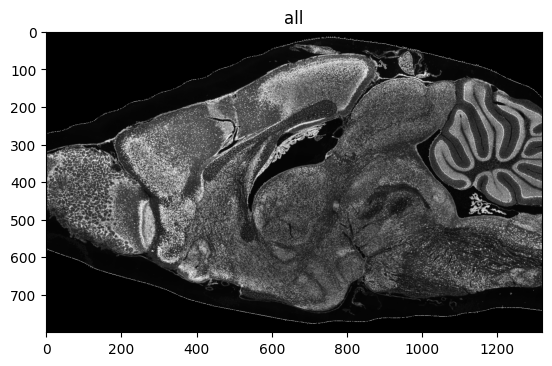

In [29]:
#arr = fixed_volume
r = sitk.Cast(resultImage, sitk.sitkUInt16)
registered_image = sitk.GetArrayFromImage(r)
plt.title('all')
plt.imshow(registered_image, cmap="gray")
plt.show()

In [ ]:
registered_image.dtype

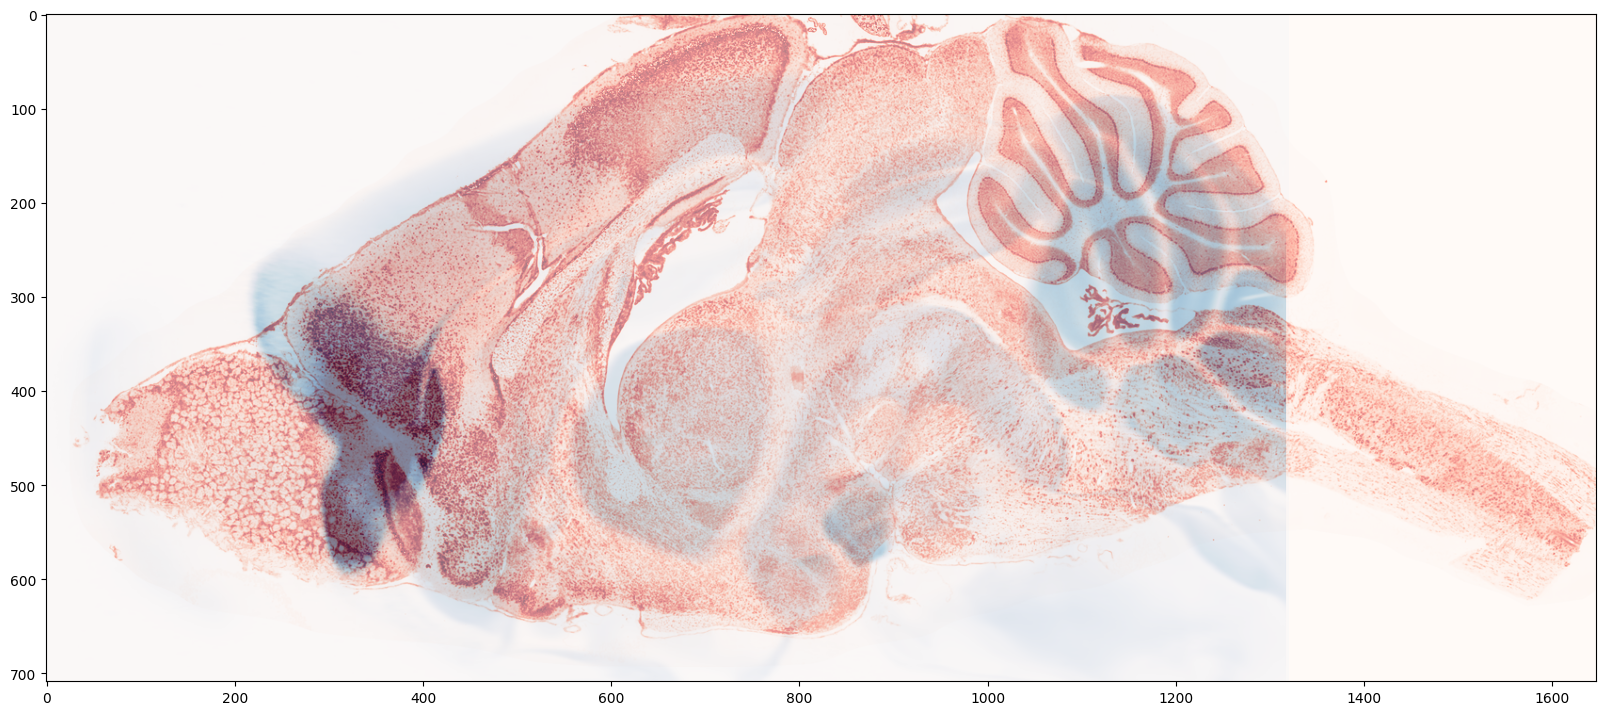

In [32]:
# 1- blue is fixed, 2 red is moving
compare_two_images(fixed_image, moving_image)

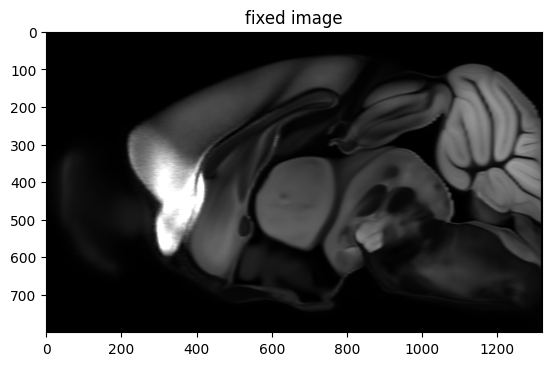

In [16]:
plt.title('fixed image')
plt.imshow(fixed_image, cmap="gray")
plt.show()

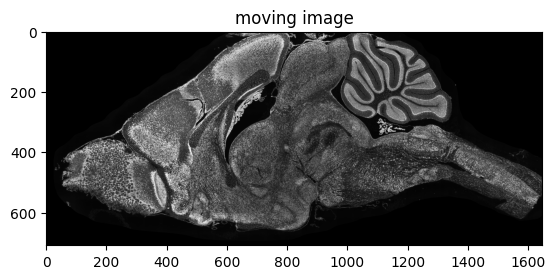

In [23]:
plt.title('moving image')
plt.imshow(moving_image, cmap="gray")
plt.show()

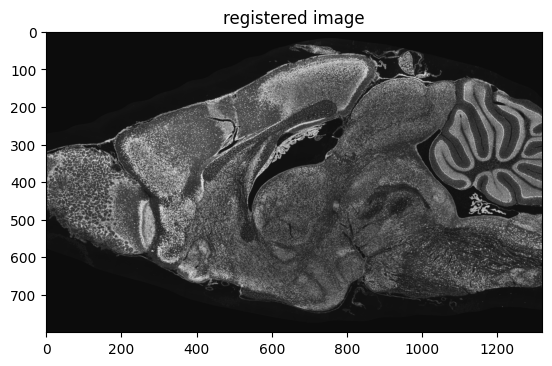

In [31]:
ri = sitk.GetArrayFromImage(resultImage)
plt.title('registered image')
plt.imshow(ri, cmap="gray")
plt.show()

In [ ]:
#scaled = zoom(moving_volume, zoom=(1, scaler, scaler))
#print(scaled.shape)
outpath = os.path.join(DATA, 'registered_243.allparams.tif')
imwrite(outpath, registered_image)
#vm2 = np.swapaxes(volume, 0,2)
#print(vm2.shape)
#outpath = os.path.join(DATA, 'allen_50um_sagittal.tif')
#imwrite(outpath, vm2)

In [ ]:
result_image_affine, result_transform_parameters = itk.elastix_registration_method(fixed, moving, parameter_object = parameter_object, log_to_console=True)
